In [2]:
!pip install statesegmentation

In [4]:
import warnings
import sys 
import os    
import glob
from statesegmentation import GSBS
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
import nibabel as nib
from nilearn.masking import apply_mask
from nltools.data import Brain_Data
from scipy.stats import zscore, norm
import datalad.api as dl

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

smallsize=14; mediumsize=16; largesize=18
plt.rc('xtick', labelsize=smallsize); plt.rc('ytick', labelsize=smallsize); plt.rc('legend', fontsize=mediumsize)
plt.rc('figure', titlesize=largesize); plt.rc('axes', labelsize=mediumsize); plt.rc('axes', titlesize=mediumsize)

ModuleNotFoundError: No module named 'brainiak'

# Load data

In [4]:
# load brain data 

base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'
data_dir = os.path.join(base_dir, 'data', 'derivatives')
denoised_dir = os.path.join(base_dir, 'analysis', 'denoised')
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'

In [5]:
# Load May Data event sequence
import scipy.io as sio
import pandas as pd

all_story = {}

subjects = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16']
for sub in subjects:
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', 'fMRI_May', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,4):
        temp = mat['subj'][0][0][7][0][i][0]
        if temp == 'Blind Date':
            temp = 'BlindDate'
        elif temp == 'Runningman':
            temp = 'RunningMan'
        elif temp == 'Way To School':
            temp = 'WayToSchool'
        elif temp == 'Business Lunch':
            temp = 'BusinessLunch'
        elif temp == 'neighbors':
            temp = 'Neighbors'
        story = np.append(story, temp)
    #all_story[str(int(sub)+8)] = story
    all_story[str(int(sub))] = story


# AG

In [81]:
mask = Brain_Data('https://neurovault.org/media/images/8423/AG_mask.nii.gz').to_nifti()

In [82]:
    
# Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D

run_1 = []
run_2 = []
blind_1 = []
blind_2 = []
dream_1 = []
dream_2 = []
neighbors_1 = []
neighbors_2 = []

movie_audio = {}
subjects = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16']
for sub in subjects:
    print(f'   Loading sub-{sub}...')
    sequence = np.where(all_story[str(int(sub))]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    
    # Masking AG ROI to Brain data 
    if int(sub) < 10 : 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
    else: 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
        
    # Trimming and Sorting data     
    for i in np.arange(0,4):
        story = all_story[sub][i]
        visual = data[onset[cond][i]:offset[cond][i]]
        audio =  data2[onset[cond][i]:offset[cond][i]]
        if story == 'RunningMan':
            run_1.append(visual)
            run_2.append(audio) 
        elif story == 'BlindDate':
            blind_1.append(visual) 
            blind_2.append(audio)
        elif story == 'Dream':
            dream_1.append(visual) 
            dream_2.append(audio)
        elif story == 'Neighbors':
            neighbors_1.append(visual)
            neighbors_2.append(audio)

   Loading sub-1...
   Loading sub-2...
   Loading sub-3...
   Loading sub-4...
   Loading sub-5...
   Loading sub-6...
   Loading sub-7...
   Loading sub-8...
   Loading sub-10...
   Loading sub-11...
   Loading sub-12...
   Loading sub-13...
   Loading sub-14...
   Loading sub-15...
   Loading sub-16...


In [83]:
#movie.append(apply_mask(file, mask))
movie_visual = {0: run_1, 1: blind_1, 2: dream_1, 3: neighbors_1}
movie_audio = {0: run_2, 1: blind_2, 2: dream_2, 3: neighbors_2}

valid_vox_v = {}
valid_vox_a = {}
group_visual = {}
group_audio = {}
for i in range(4):
    valid_vox_v[i] = reduce(np.union1d, [np.where(np.std(m_v, axis=0)>0)[0] for m_v in movie_visual[i]])
    valid_vox_a[i] = reduce(np.union1d, [np.where(np.std(m_A, axis=0)>0)[0] for m_A in movie_audio[i]])
    movie_visual[i] = [m_v[:,valid_vox_v[i]] for  m_v in movie_visual[i]]
    movie_audio[i] = [m_A[:,valid_vox_v[i]] for  m_A in movie_audio[i]]
    group_visual[i] = np.mean(movie_visual[i], axis = 0) 
    group_audio[i] = np.mean(movie_audio[i], axis = 0) 


In [85]:
sequence = all_story['1']

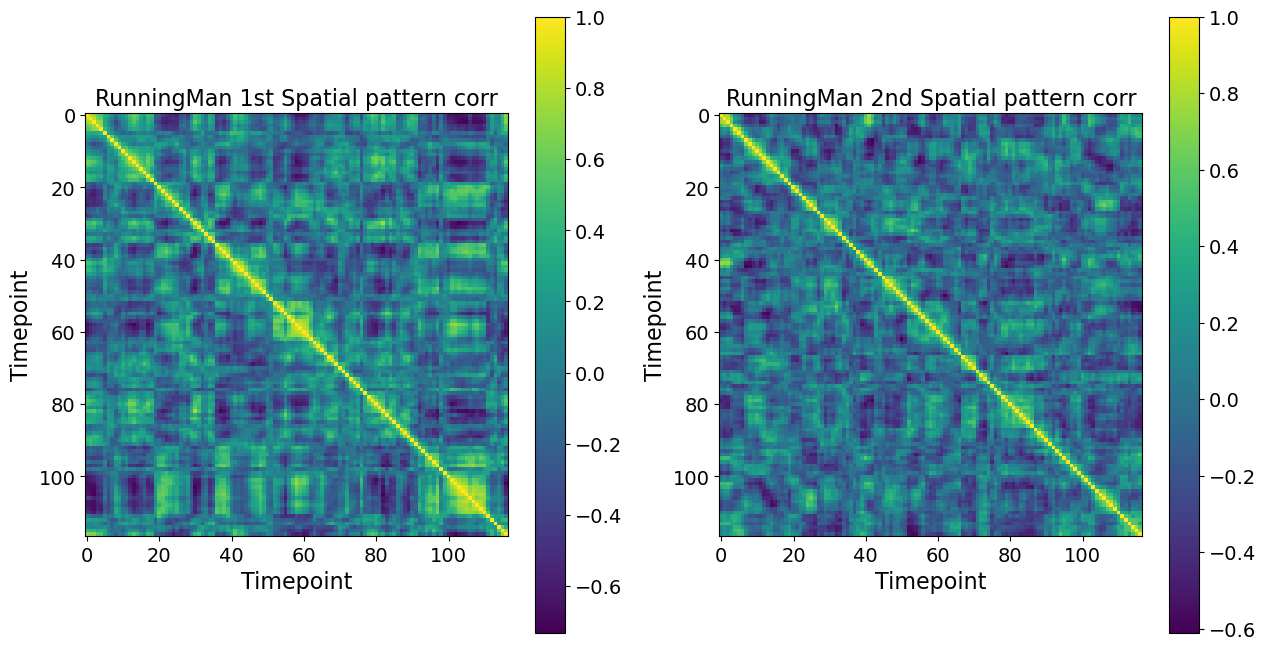

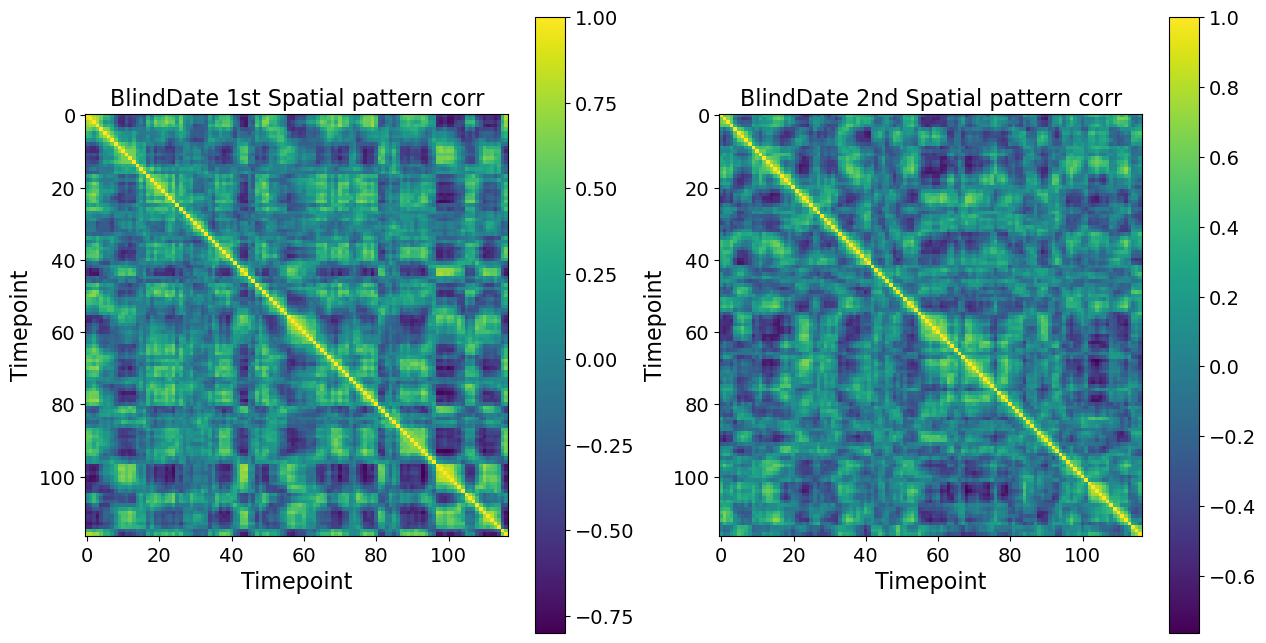

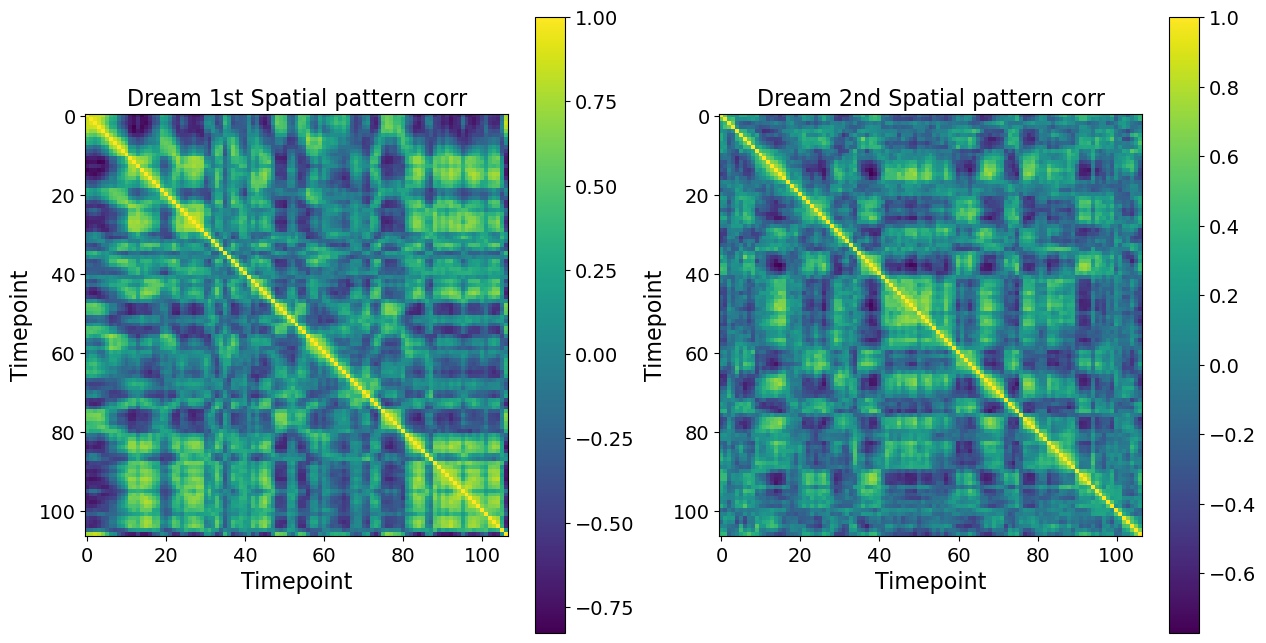

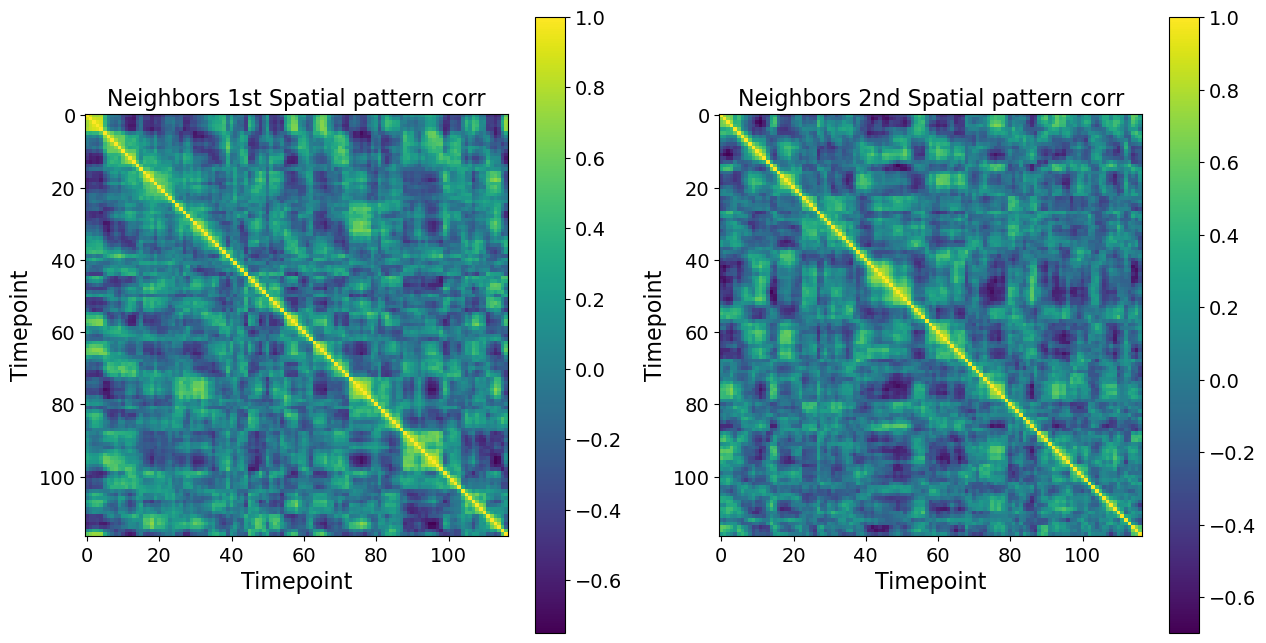

In [86]:
# Event structure in activity patterns
for i in range(4):

    plt.figure(figsize=(15,8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.corrcoef( group_visual[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Spatial pattern corr');

    plt.subplot(1, 2, 2)
    plt.imshow(np.corrcoef( group_audio[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Spatial pattern corr');

In [87]:
#Fitting the HMM
movie_HMM_v = {}
movie_HMM_a = {}
for i in range(4):
    movie_HMM_v[i] = EventSegment(n_events = 4)
    movie_HMM_v[i].fit(group_visual[i]);
    movie_HMM_a[i] = EventSegment(n_events = 4)
    movie_HMM_a[i].fit(group_audio[i]);

<Figure size 1200x600 with 0 Axes>

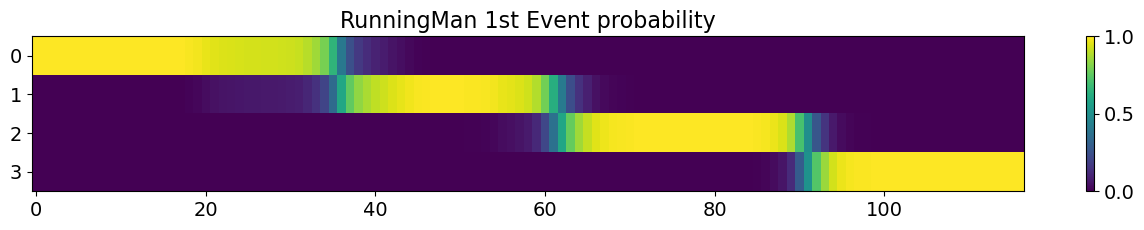

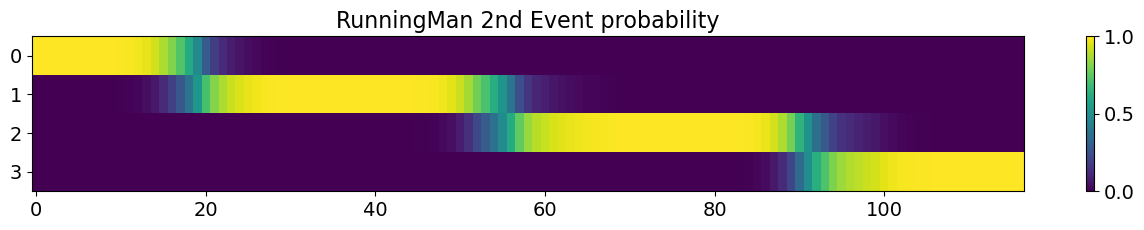

<Figure size 1200x600 with 0 Axes>

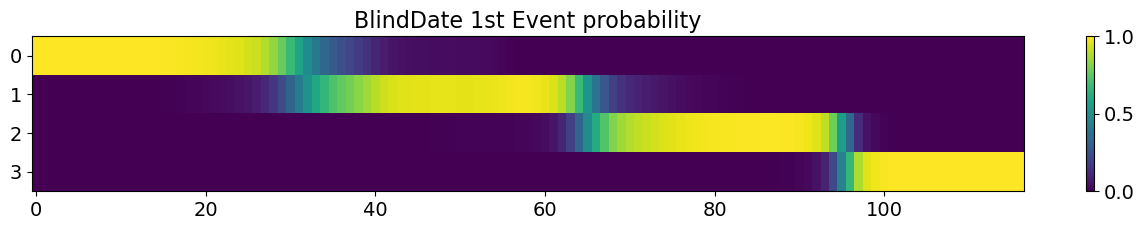

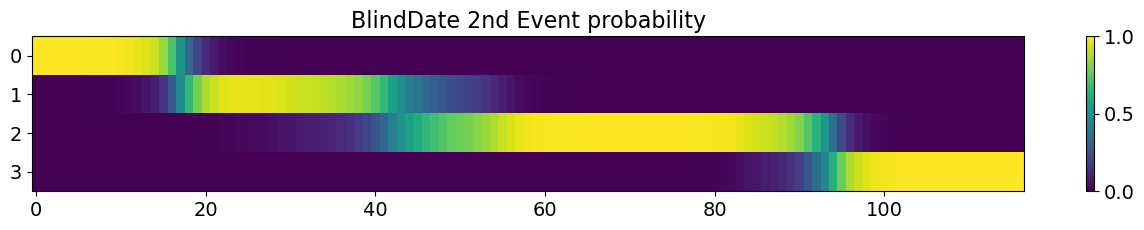

<Figure size 1200x600 with 0 Axes>

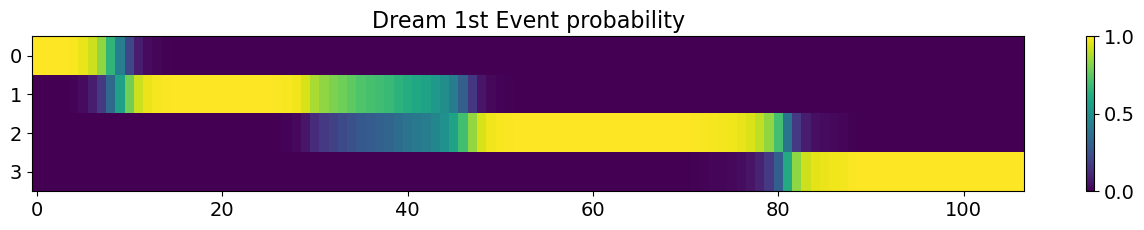

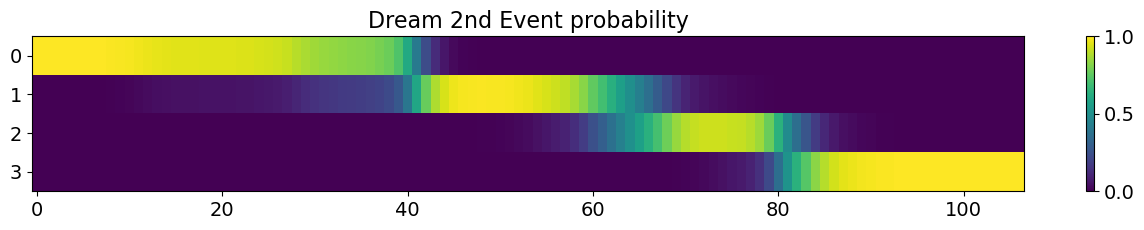

<Figure size 1200x600 with 0 Axes>

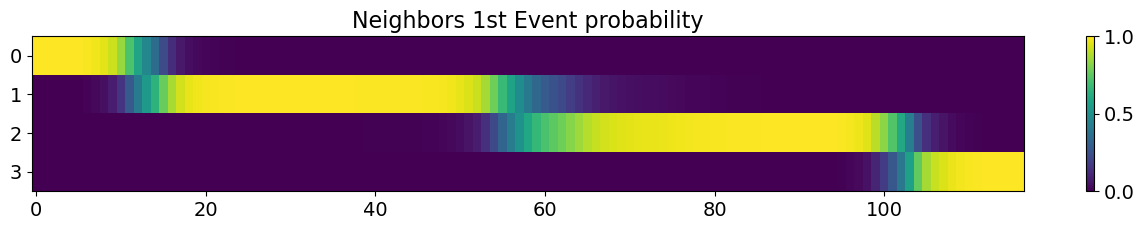

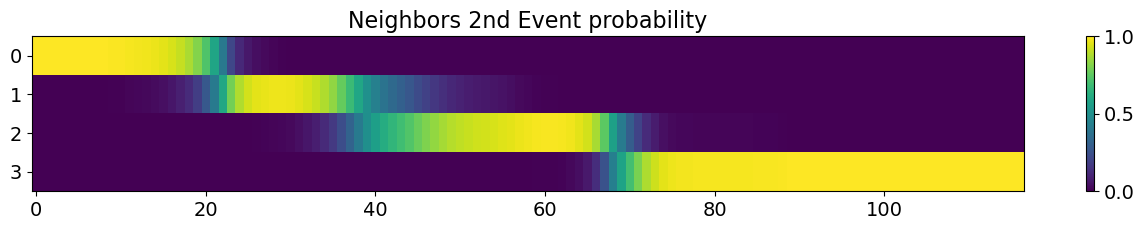

In [88]:
# Plot probability of being in each event at each timepoint
# Plotting mean activity in each event for some example voxels
for i in range(4):
    
    plt.figure(figsize = (12, 6))
    
    plt.matshow(movie_HMM_v[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Event probability')
    
    plt.matshow(movie_HMM_a[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Event probability')

## Event boundary check 

In [64]:
run_sequence = movie_HMM_v[0].segments_[0].T
run_sequence2 = movie_HMM_a[0].segments_[0].T

In [164]:
run_df = pd.DataFrame({'E1':np.round(run_sequence[0,:]), 'E2': np.round(run_sequence[1,:]), 'E3': np.round(run_sequence[2,:]), 'E4': np.round(run_sequence[3,:]) })
run_df2 = pd.DataFrame({'E1':np.round(run_sequence2[0,:]), 'E2': np.round(run_sequence2[1,:]), 'E3': np.round(run_sequence2[2,:]), 'E4': np.round(run_sequence2[3,:]) })

run_df2[(run_df2['E1'] == 1)]

E1   E2   E3   E4
0  1.0  0.0  0.0  0.0
1  1.0  0.0  0.0  0.0
2  1.0  0.0  0.0  0.0
3  1.0  0.0  0.0  0.0
4  1.0  0.0  0.0  0.0
5  1.0  0.0  0.0  0.0
6  1.0  0.0  0.0  0.0

# HPC

In [88]:
# Hippocampus Harvard-Oxford mask
mask = Brain_Data('http://neurovault.org/media/images/6126/hippho50.nii.gz').to_nifti()

In [89]:
    
# Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D

run_1 = []
run_2 = []
blind_1 = []
blind_2 = []
dream_1 = []
dream_2 = []
neighbors_1 = []
neighbors_2 = []

movie_audio = {}
subjects = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16']
for sub in subjects:
    print(f'   Loading sub-{sub}...')
    sequence = np.where(all_story[str(int(sub))]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    
    # Masking AG ROI to Brain data 
    if int(sub) < 10 : 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
    else: 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
        
    # Trimming and Sorting data     
    for i in np.arange(0,4):
        story = all_story[sub][i]
        visual = data[onset[cond][i]:offset[cond][i]]
        audio =  data2[onset[cond][i]:offset[cond][i]]
        if story == 'RunningMan':
            run_1.append(visual)
            run_2.append(audio) 
        elif story == 'BlindDate':
            blind_1.append(visual) 
            blind_2.append(audio)
        elif story == 'Dream':
            dream_1.append(visual) 
            dream_2.append(audio)
        elif story == 'Neighbors':
            neighbors_1.append(visual)
            neighbors_2.append(audio)

   Loading sub-1...
   Loading sub-2...
   Loading sub-3...
   Loading sub-4...
   Loading sub-5...
   Loading sub-6...
   Loading sub-7...
   Loading sub-8...
   Loading sub-10...
   Loading sub-11...
   Loading sub-12...
   Loading sub-13...
   Loading sub-14...
   Loading sub-15...
   Loading sub-16...


In [90]:
#movie.append(apply_mask(file, mask))
movie_visual = {0: run_1, 1: blind_1, 2: dream_1, 3: neighbors_1}
movie_audio = {0: run_2, 1: blind_2, 2: dream_2, 3: neighbors_2}

valid_vox_v = {}
valid_vox_a = {}
group_visual = {}
group_audio = {}
for i in range(4):
    valid_vox_v[i] = reduce(np.union1d, [np.where(np.std(m_v, axis=0)>0)[0] for m_v in movie_visual[i]])
    valid_vox_a[i] = reduce(np.union1d, [np.where(np.std(m_A, axis=0)>0)[0] for m_A in movie_audio[i]])
    movie_visual[i] = [m_v[:,valid_vox_v[i]] for  m_v in movie_visual[i]]
    movie_audio[i] = [m_A[:,valid_vox_v[i]] for  m_A in movie_audio[i]]
    group_visual[i] = np.mean(movie_visual[i], axis = 0) 
    group_audio[i] = np.mean(movie_audio[i], axis = 0) 

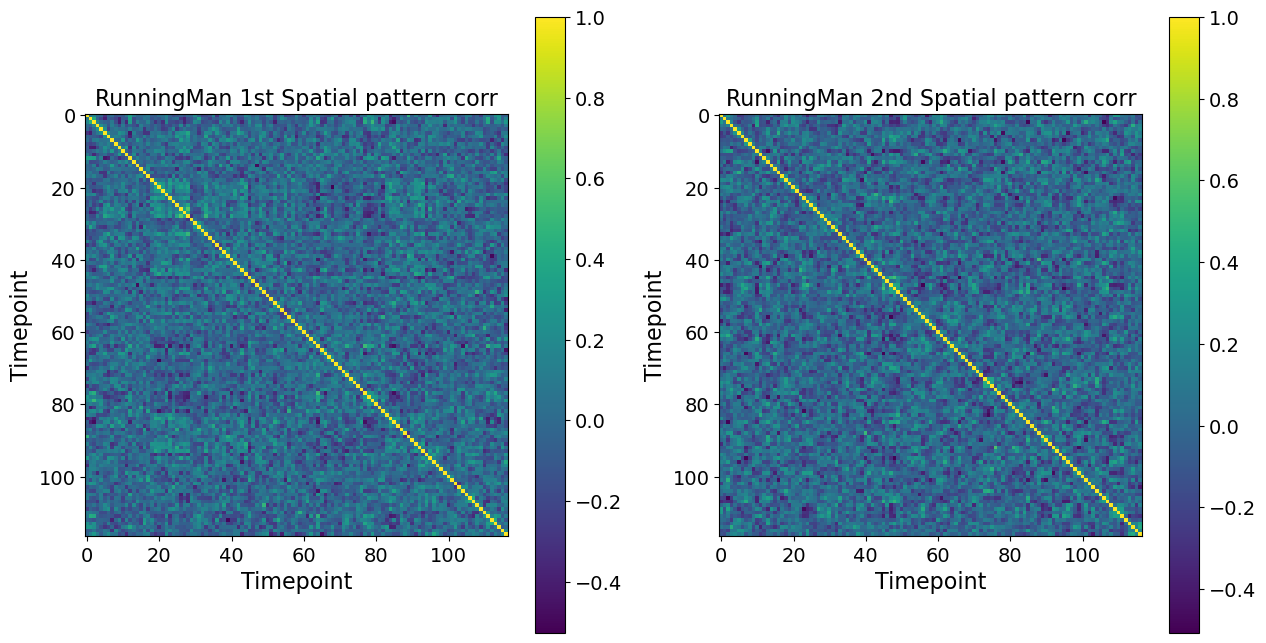

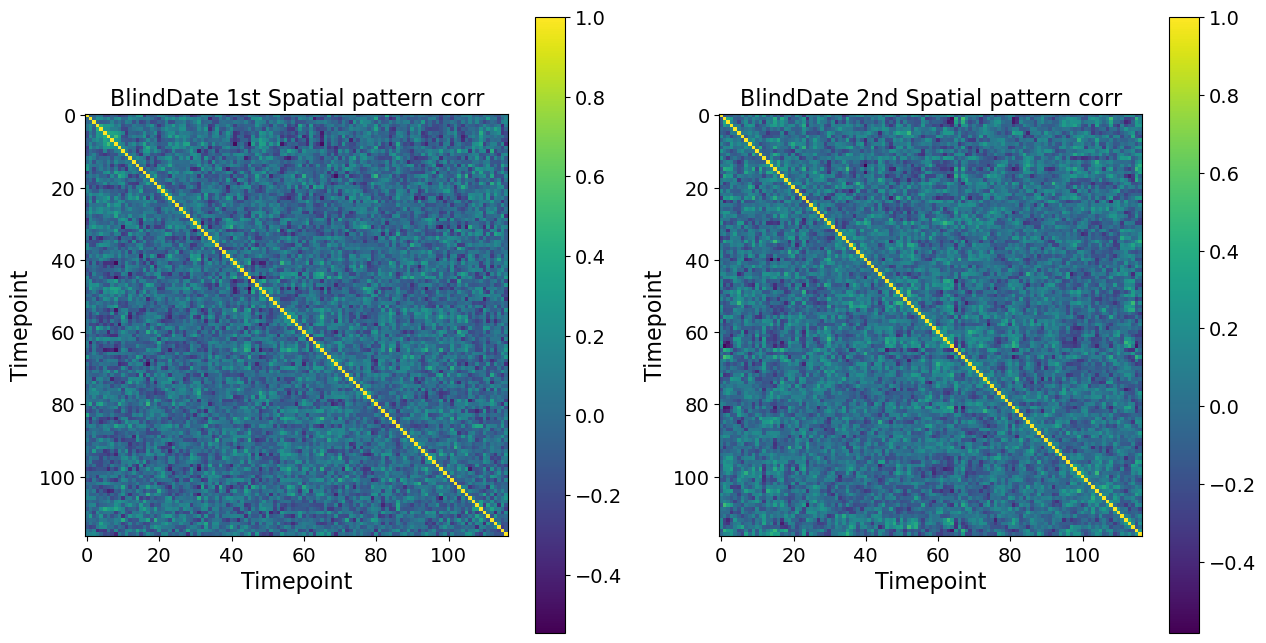

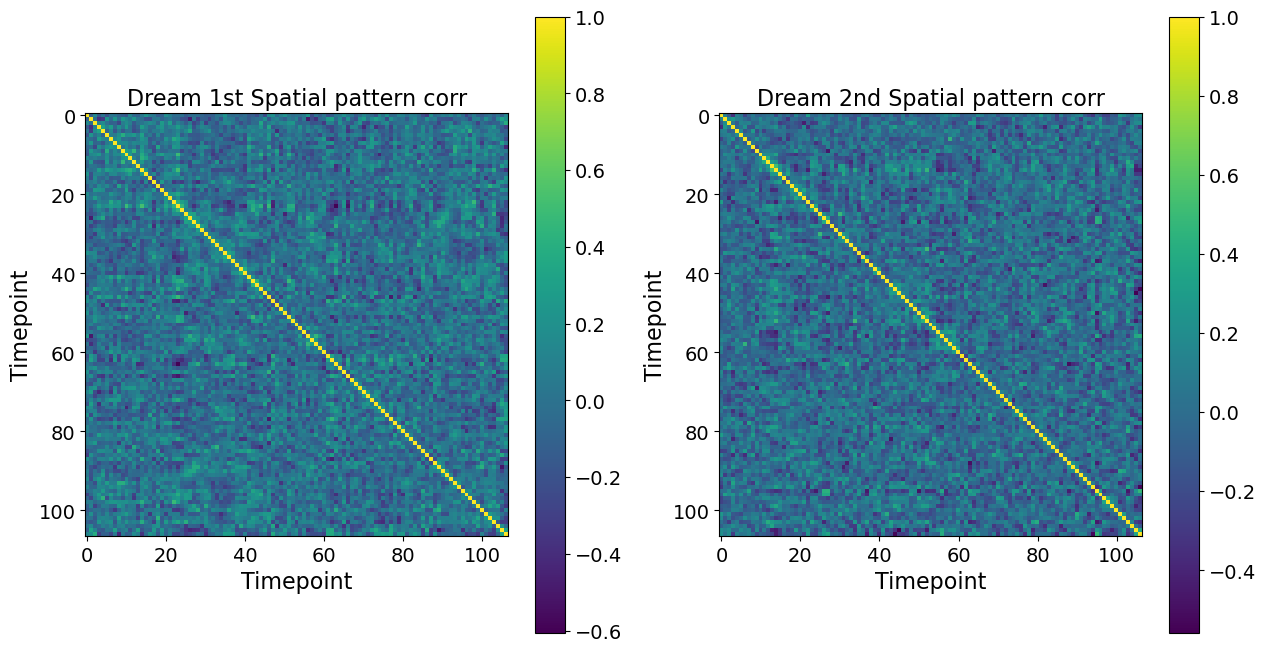

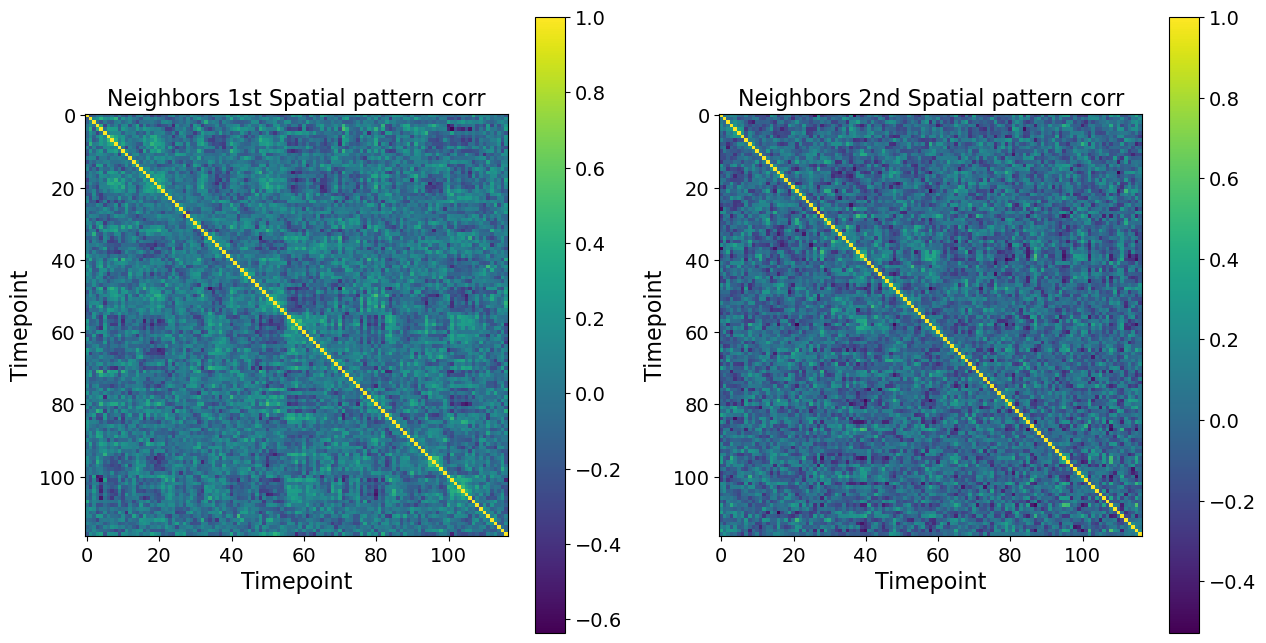

In [92]:
# Event structure in activity patterns
sequence = all_story['1']

for i in range(4):

    plt.figure(figsize=(15,8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.corrcoef( group_visual[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Spatial pattern corr');

    plt.subplot(1, 2, 2)
    plt.imshow(np.corrcoef( group_audio[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Spatial pattern corr');

<Figure size 1200x600 with 0 Axes>

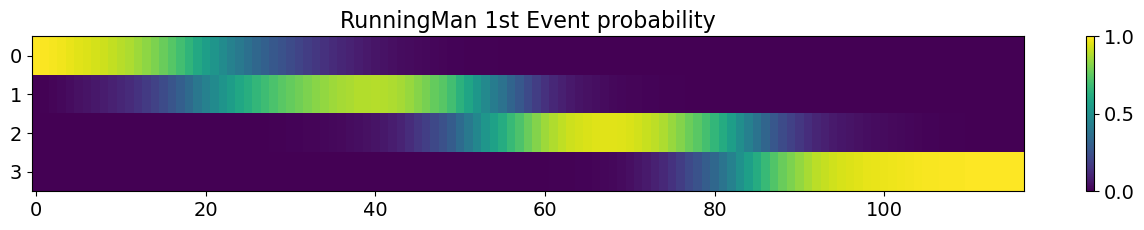

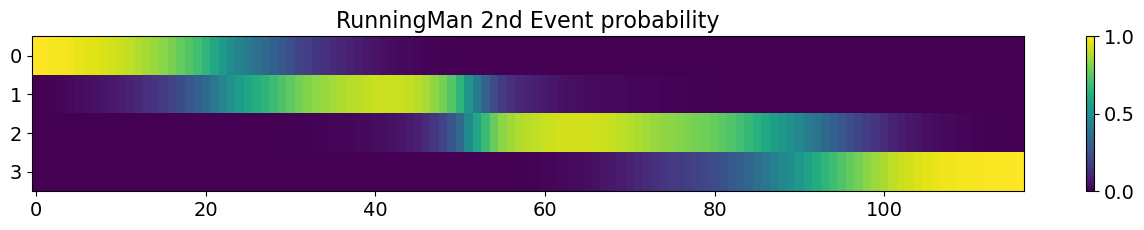

<Figure size 1200x600 with 0 Axes>

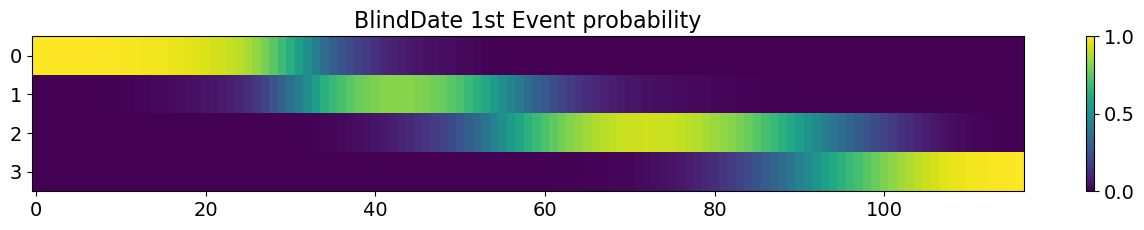

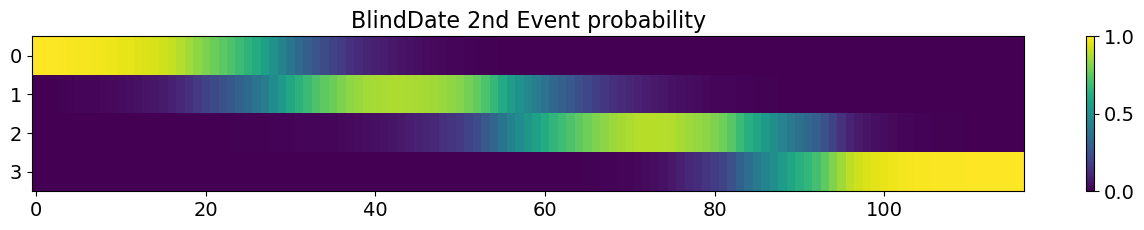

<Figure size 1200x600 with 0 Axes>

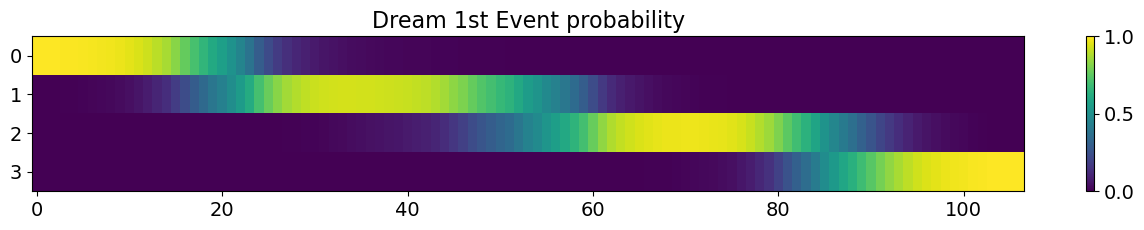

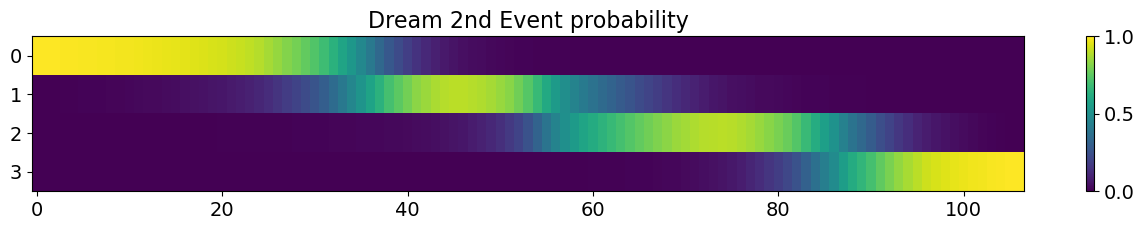

<Figure size 1200x600 with 0 Axes>

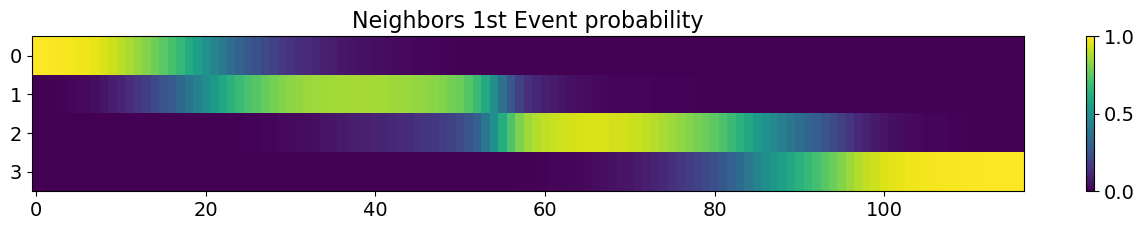

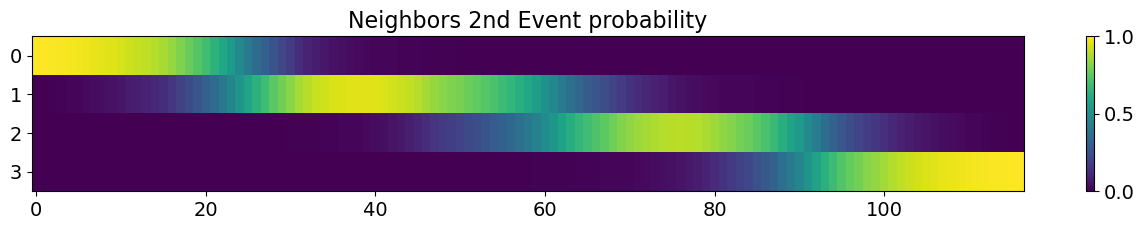

In [99]:
#Fitting the HMM
movie_HMM_v = {}
movie_HMM_a = {}
for i in range(4):
    movie_HMM_v[i] = EventSegment(n_events = 4)
    movie_HMM_v[i].fit(group_visual[i]);
    movie_HMM_a[i] = EventSegment(n_events = 4)
    movie_HMM_a[i].fit(group_audio[i]);
    
    plt.figure(figsize = (12, 6))
    
    plt.matshow(movie_HMM_v[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Event probability')
    
    plt.matshow(movie_HMM_a[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Event probability')

## Plotting

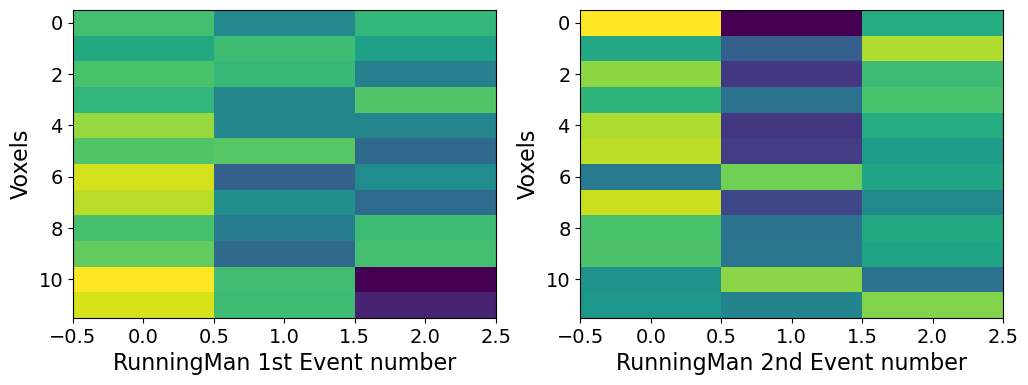

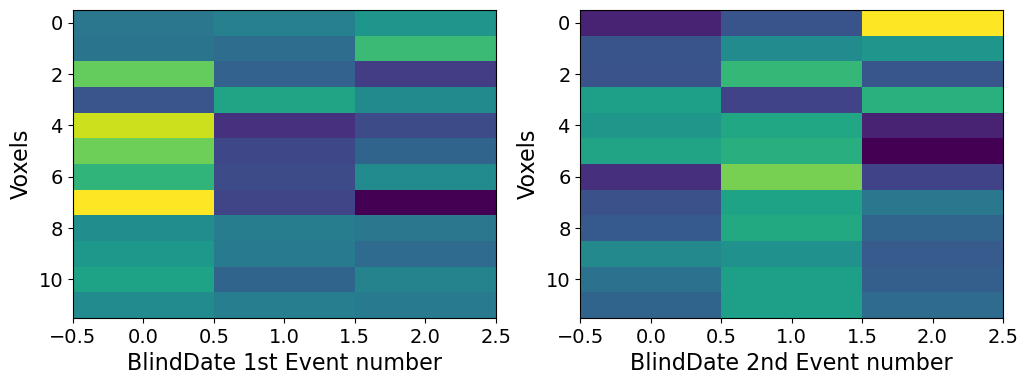

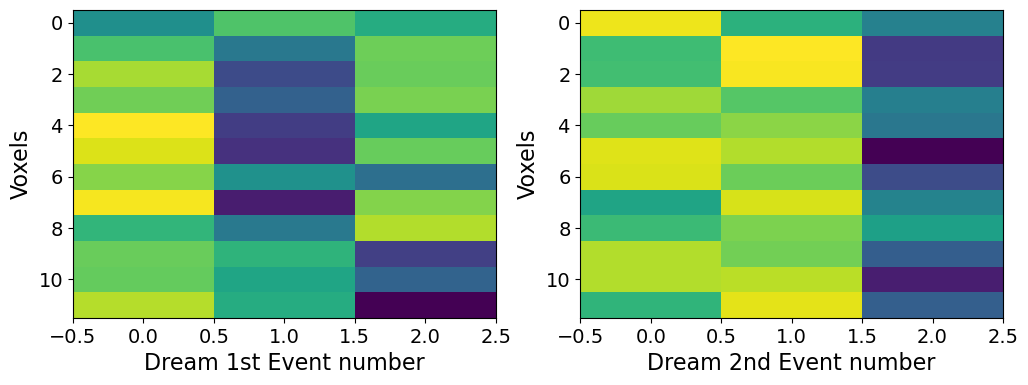

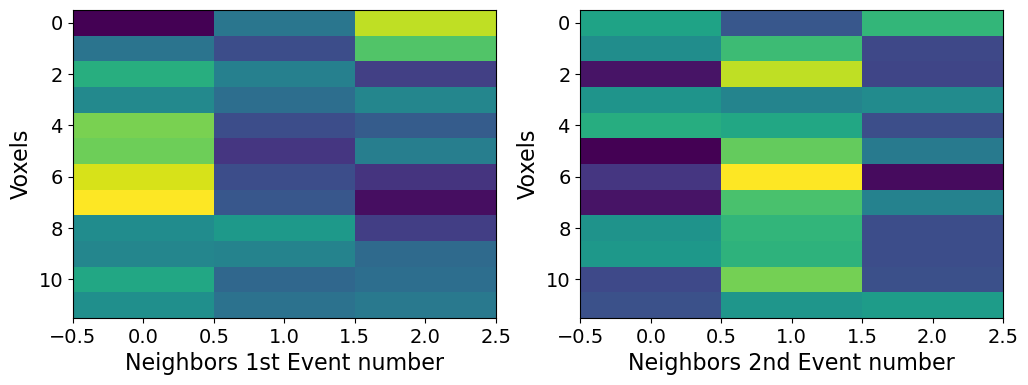

In [98]:
# Plotting mean activity in each event for some example voxels
for i in range(4):
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    example_vox = np.arange(0,movie_HMM_v[i].event_pat_.shape[0],100)
    plt.imshow(movie_HMM_v[i].event_pat_[example_vox,:], aspect='auto')
    plt.xlabel(f'{sequence[i]} 1st Event number')
    plt.ylabel('Voxels')
    
    plt.subplot(1, 2, 2)
    example_vox = np.arange(0,movie_HMM_a[i].event_pat_.shape[0],100)
    plt.imshow(movie_HMM_a[i].event_pat_[example_vox,:], aspect='auto')
    plt.xlabel(f'{sequence[i]} 2nd Event number')
    plt.ylabel('Voxels')

# PCC2 

In [15]:
# PCC Harvard-Oxford mask
#mask = Brain_Data('http://neurovault.org/media/images/8129/PCC_SL.nii.gz').to_nifti()
#mask2 = Brain_Data('http://neurovault.org/media/images/2462/seed_PCC_vox200.nii.gz').to_nifti()
mask = Brain_Data('http://neurovault.org/media/images/2275/PMC-3.nii.gz').to_nifti()

# PCC 1 

## PCC HMM fitting

In [17]:
# PCC Harvard-Oxford mask
mask = Brain_Data('http://neurovault.org/media/images/8129/PCC_SL.nii.gz').to_nifti()
#Collection: Value shapes the structure of schematic representations in the medial prefrontal cortex


In [18]:
# Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D

run_1 = []
run_2 = []
blind_1 = []
blind_2 = []
dream_1 = []
dream_2 = []
neighbors_1 = []
neighbors_2 = []

movie_audio = {}
subjects = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16']
for sub in subjects:
    print(f'   Loading sub-{sub}...')
    sequence = np.where(all_story[str(int(sub))]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    
    # Masking AG ROI to Brain data 
    if int(sub) < 10 : 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
    else: 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
        
    # Trimming and Sorting data     
    for i in np.arange(0,4):
        story = all_story[sub][i]
        visual = data[onset[cond][i]:offset[cond][i]]
        audio =  data2[onset[cond][i]:offset[cond][i]]
        if story == 'RunningMan':
            run_1.append(visual)
            run_2.append(audio) 
        elif story == 'BlindDate':
            blind_1.append(visual) 
            blind_2.append(audio)
        elif story == 'Dream':
            dream_1.append(visual) 
            dream_2.append(audio)
        elif story == 'Neighbors':
            neighbors_1.append(visual)
            neighbors_2.append(audio)

   Loading sub-1...
   Loading sub-2...
   Loading sub-3...
   Loading sub-4...
   Loading sub-5...
   Loading sub-6...
   Loading sub-7...
   Loading sub-8...
   Loading sub-10...
   Loading sub-11...
   Loading sub-12...
   Loading sub-13...
   Loading sub-14...
   Loading sub-15...
   Loading sub-16...


In [19]:
#movie.append(apply_mask(file, mask))
movie_visual = {0: run_1, 1: blind_1, 2: dream_1, 3: neighbors_1}
movie_audio = {0: run_2, 1: blind_2, 2: dream_2, 3: neighbors_2}

valid_vox_v = {}
valid_vox_a = {}
group_visual = {}
group_audio = {}
for i in range(4):
    valid_vox_v[i] = reduce(np.union1d, [np.where(np.std(m_v, axis=0)>0)[0] for m_v in movie_visual[i]])
    valid_vox_a[i] = reduce(np.union1d, [np.where(np.std(m_A, axis=0)>0)[0] for m_A in movie_audio[i]])
    movie_visual[i] = [m_v[:,valid_vox_v[i]] for  m_v in movie_visual[i]]
    movie_audio[i] = [m_A[:,valid_vox_v[i]] for  m_A in movie_audio[i]]
    group_visual[i] = np.mean(movie_visual[i], axis = 0) 
    group_audio[i] = np.mean(movie_audio[i], axis = 0) 

In [20]:
sequence = all_story['1']

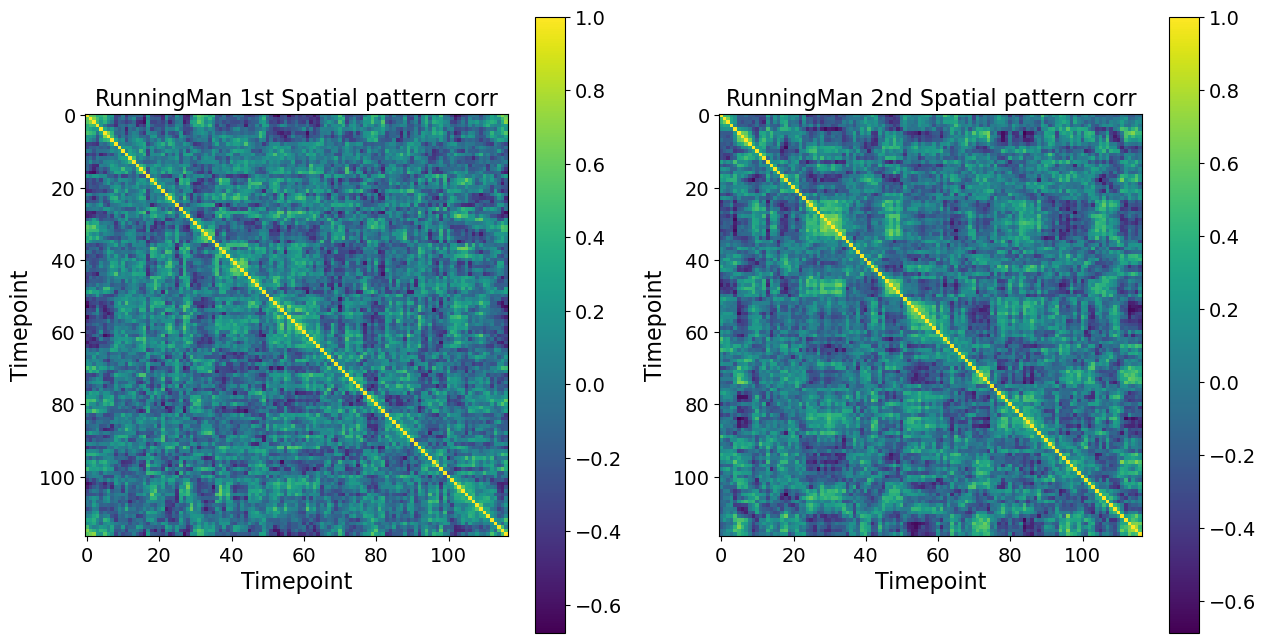

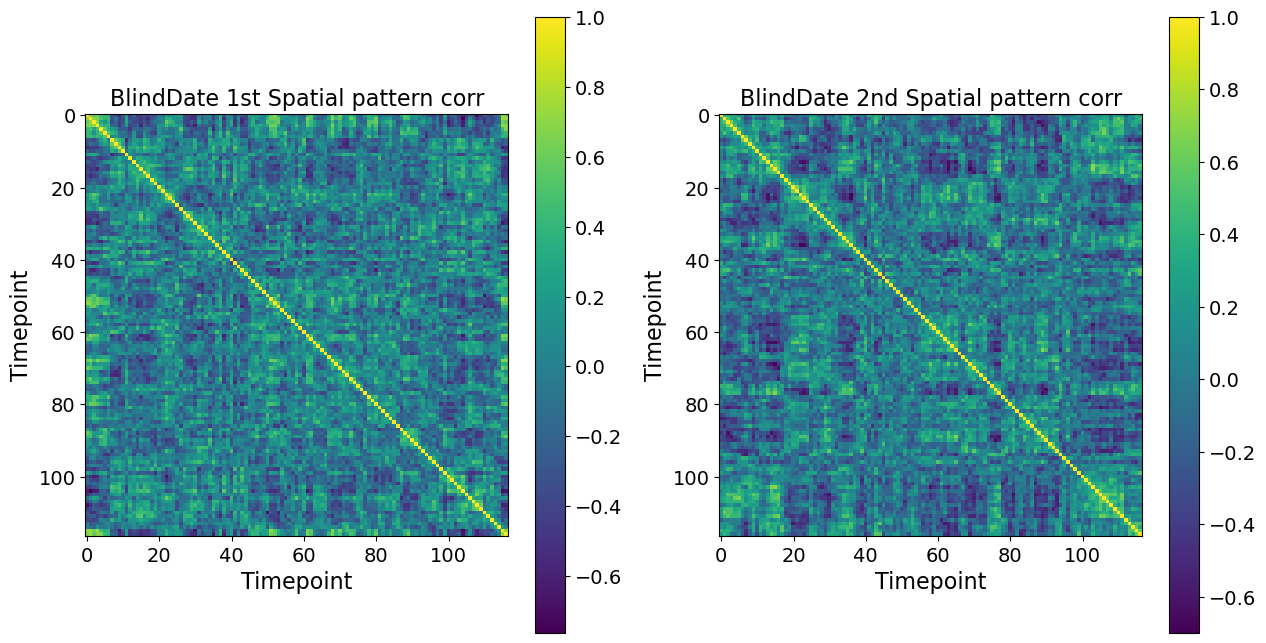

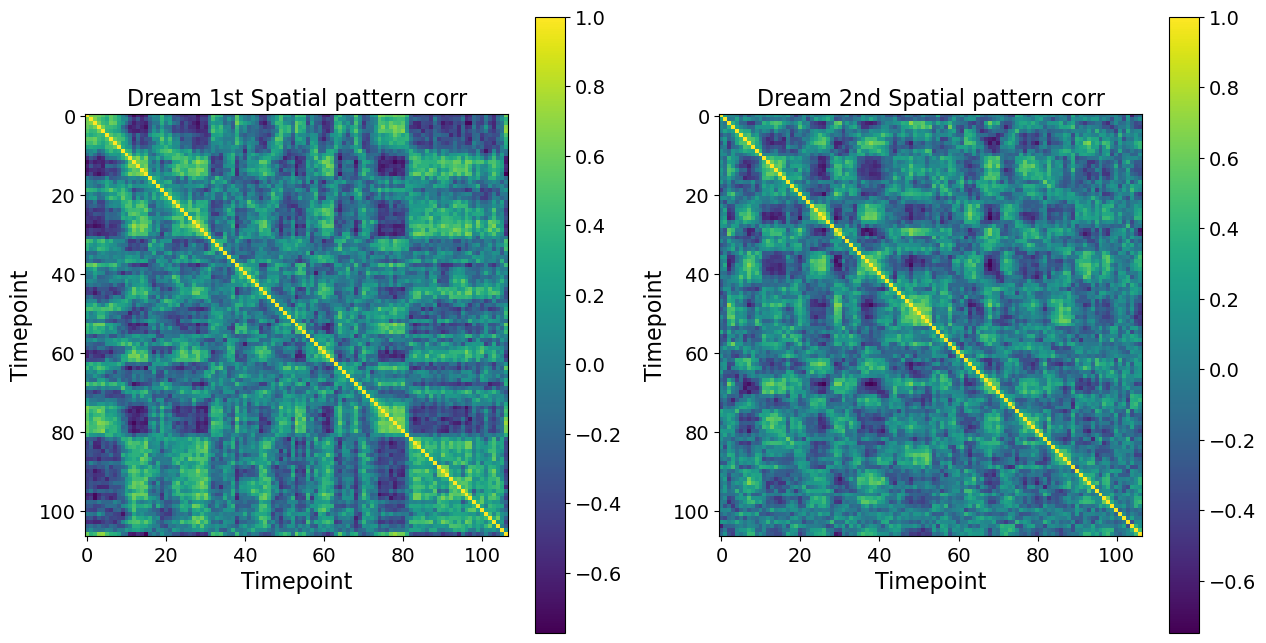

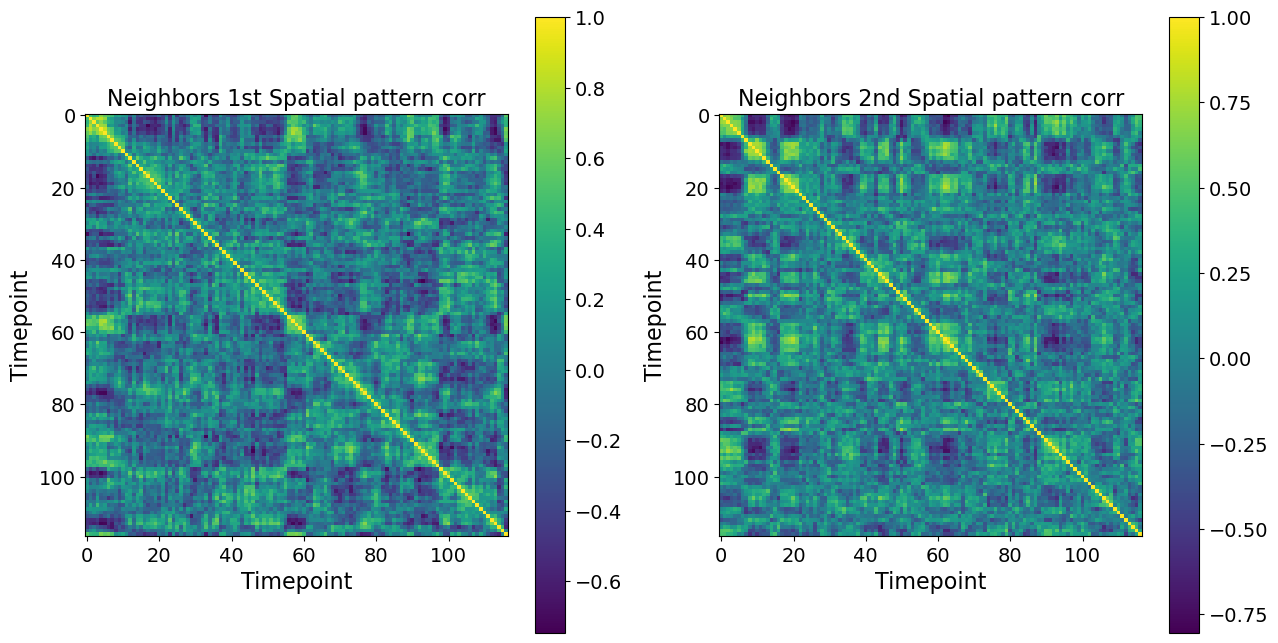

In [21]:

# Event structure in activity patterns
for i in range(4):

    plt.figure(figsize=(15,8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.corrcoef( group_visual[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Spatial pattern corr');

    plt.subplot(1, 2, 2)
    plt.imshow(np.corrcoef( group_audio[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Spatial pattern corr');

<Figure size 1200x600 with 0 Axes>

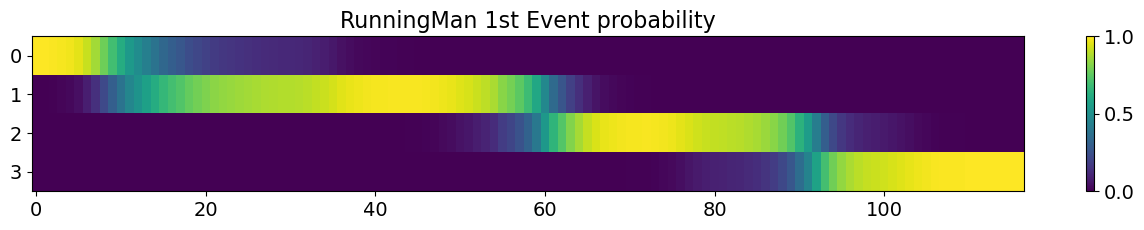

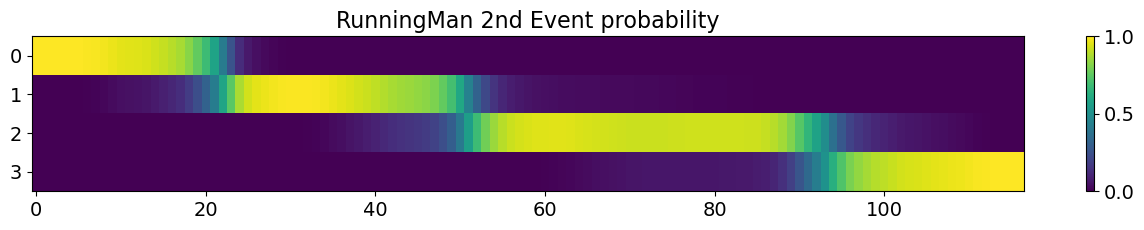

<Figure size 1200x600 with 0 Axes>

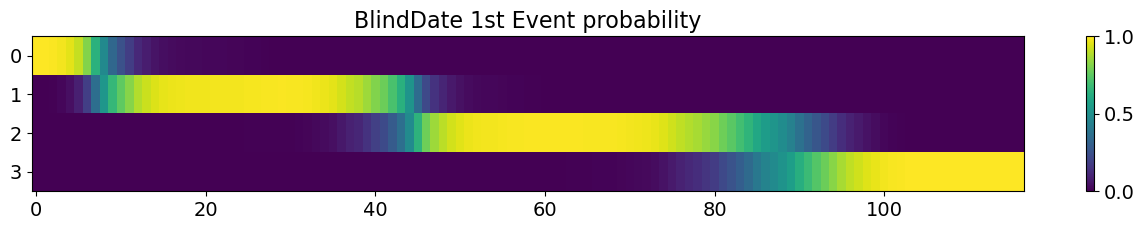

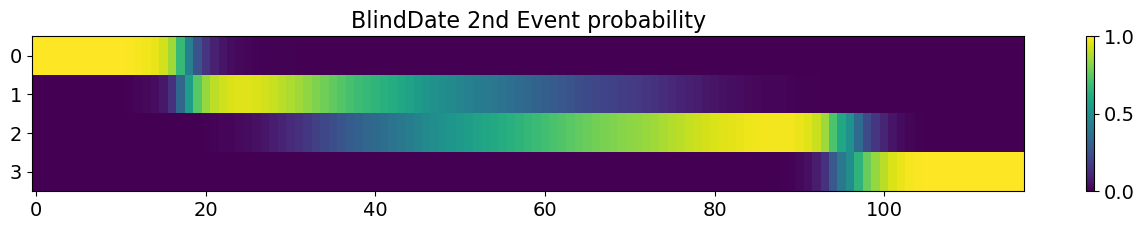

<Figure size 1200x600 with 0 Axes>

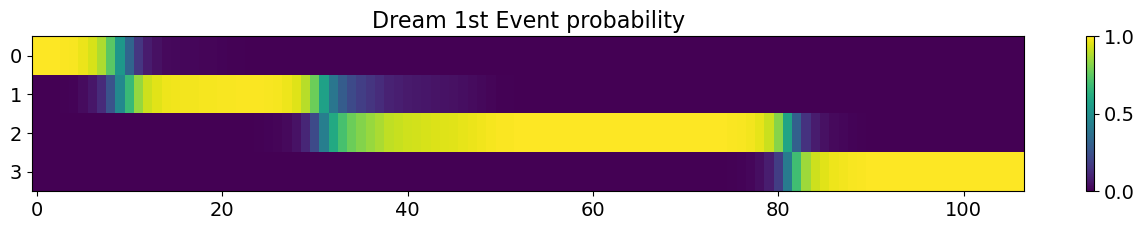

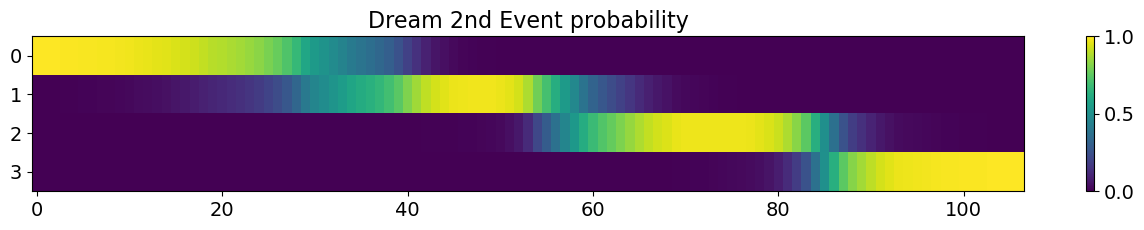

<Figure size 1200x600 with 0 Axes>

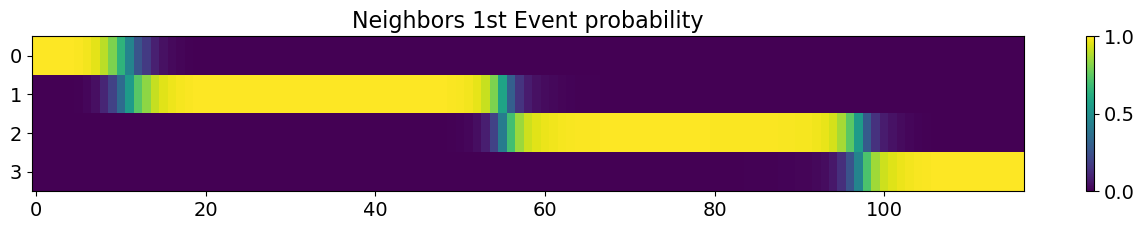

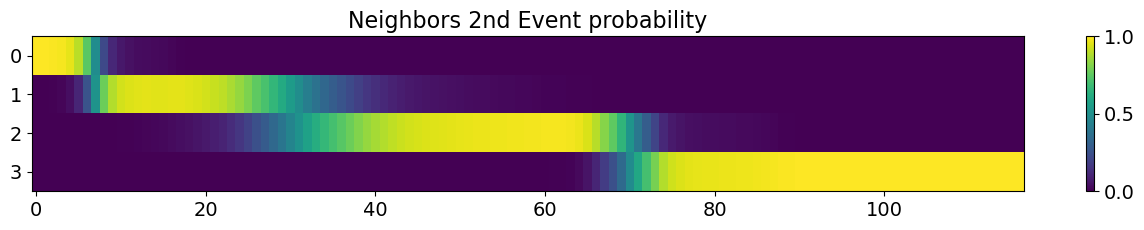

In [73]:
#Fitting the HMM
movie_HMM_v = {}
movie_HMM_a = {}
for i in range(4):
    movie_HMM_v[i] = EventSegment(n_events = 4)
    movie_HMM_v[i].fit(group_visual[i]);
    movie_HMM_a[i] = EventSegment(n_events = 4)
    movie_HMM_a[i].fit(group_audio[i]);
    
    plt.figure(figsize = (12, 6))
    
    plt.matshow(movie_HMM_v[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Event probability')
    
    plt.matshow(movie_HMM_a[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Event probability')

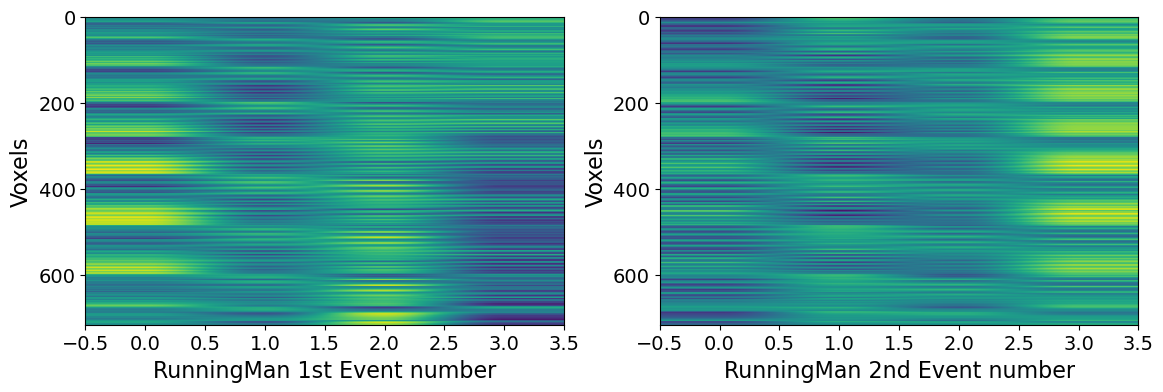

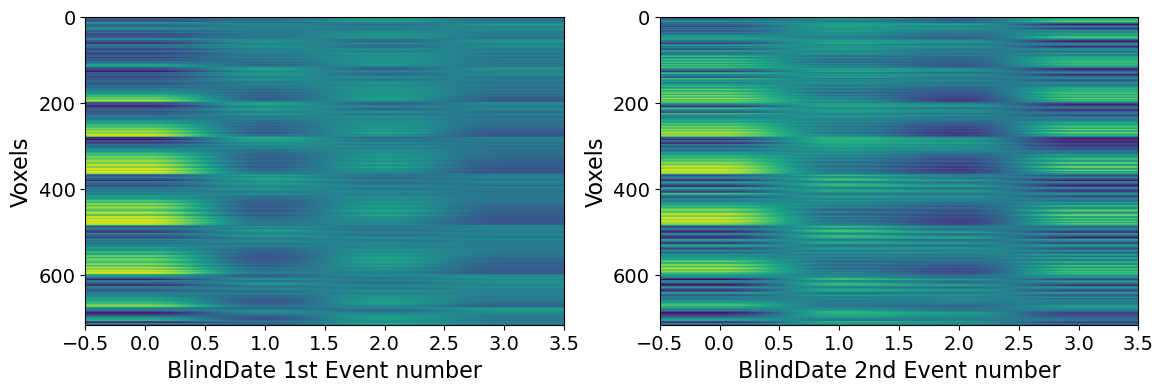

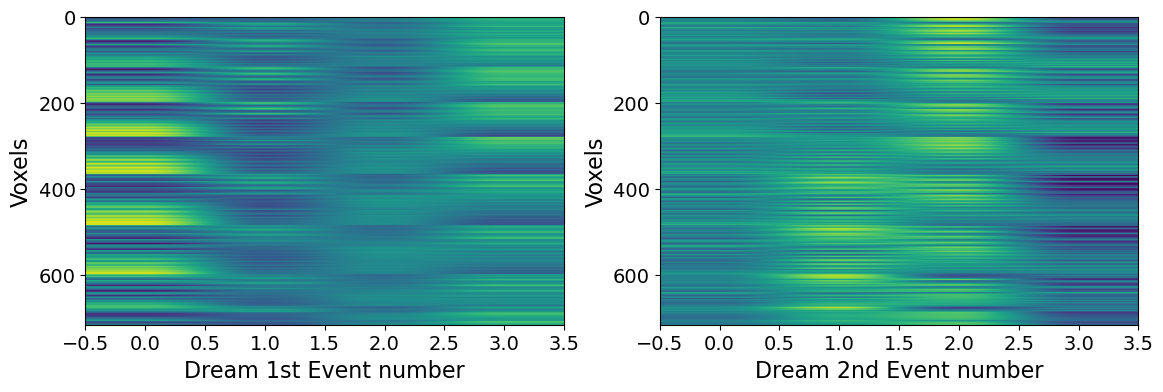

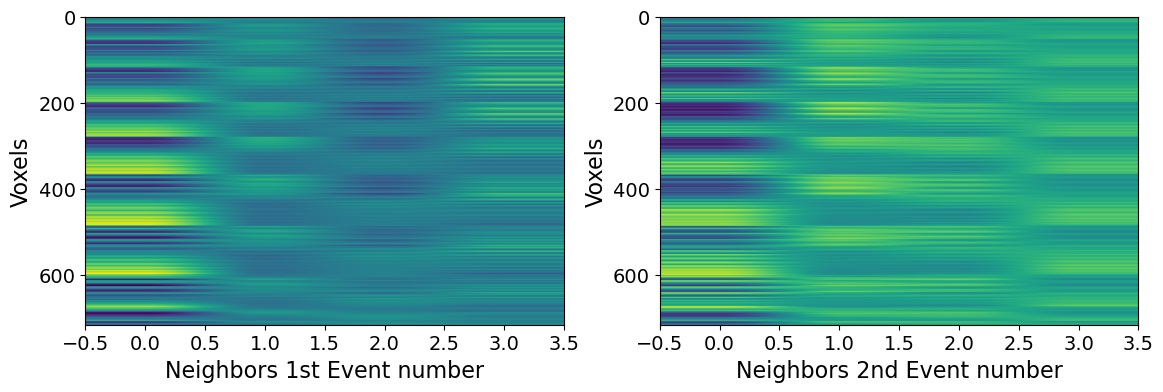

In [76]:
# Plotting mean activity in each event for some example voxels
for i in range(4):
    plt.figure(figsize = (21, 4))
    plt.subplot(1, 3, 1)
    example_vox = np.arange(0,movie_HMM_v[i].event_pat_.shape[0])
    plt.imshow(movie_HMM_v[i].event_pat_[example_vox,:], aspect='auto')
    plt.xlabel(f'{sequence[i]} 1st Event number')
    plt.ylabel('Voxels')
    
    plt.subplot(1, 3, 2)
    example_vox = np.arange(0,movie_HMM_a[i].event_pat_.shape[0])
    plt.imshow(movie_HMM_a[i].event_pat_[example_vox,:], aspect='auto')
    plt.xlabel(f'{sequence[i]} 2nd Event number')
    plt.ylabel('Voxels')
    
    
#     plt.subplot(1, 3, 3)
#     example_vox = np.arange(0,movie_HMM_a[i].event_pat_.shape[0])
#     diff = movie_HMM_a[i].event_pat_[example_vox,:] - movie_HMM_v[i].event_pat_[example_vox,:]
#     plt.imshow(diff, aspect='auto')
#     plt.xlabel(f'{sequence[i]} difference ')
#     plt.ylabel('Voxels')

## Event boundary check 

In [64]:
run_sequence = movie_HMM_v[3].segments_[0].T
run_sequence2 = movie_HMM_a[3].segments_[0].T

In [72]:
run_df = pd.DataFrame({'E1':np.round(run_sequence[0,:]), 'E2': np.round(run_sequence[1,:]), 'E3': np.round(run_sequence[2,:]), 'E4': np.round(run_sequence[3,:]) })
run_df2 = pd.DataFrame({'E1':np.round(run_sequence2[0,:]), 'E2': np.round(run_sequence2[1,:]), 'E3': np.round(run_sequence2[2,:]), 'E4': np.round(run_sequence2[3,:]) })

run_df2[(run_df2['E4'] == 1)]

E1   E2   E3   E4
71   0.0  0.0  0.0  1.0
72   0.0  0.0  0.0  1.0
73   0.0  0.0  0.0  1.0
74   0.0  0.0  0.0  1.0
75   0.0  0.0  0.0  1.0
76   0.0  0.0  0.0  1.0
77   0.0  0.0  0.0  1.0
78   0.0  0.0  0.0  1.0
79   0.0  0.0  0.0  1.0
80   0.0  0.0  0.0  1.0
81   0.0  0.0  0.0  1.0
82   0.0  0.0  0.0  1.0
83   0.0  0.0  0.0  1.0
84   0.0  0.0  0.0  1.0
85   0.0  0.0  0.0  1.0
86   0.0  0.0  0.0  1.0
87   0.0  0.0  0.0  1.0
88   0.0  0.0  0.0  1.0
89   0.0  0.0  0.0  1.0
90   0.0  0.0  0.0  1.0
91   0.0  0.0  0.0  1.0
92   0.0  0.0  0.0  1.0
93   0.0  0.0  0.0  1.0
94   0.0  0.0  0.0  1.0
95   0.0  0.0  0.0  1.0
96   0.0  0.0  0.0  1.0
97   0.0  0.0  0.0  1.0
98   0.0  0.0  0.0  1.0
99   0.0  0.0  0.0  1.0
100  0.0  0.0  0.0  1.0
101  0.0  0.0  0.0  1.0
102  0.0  0.0  0.0  1.0
103  0.0  0.0  0.0  1.0
104  0.0  0.0  0.0  1.0
105  0.0  0.0  0.0  1.0
106  0.0  0.0  0.0  1.0
107  0.0  0.0  0.0  1.0
108  0.0  0.0  0.0  1.0
109  0.0  0.0  0.0  1.0
110  0.0  0.0  0.0  1.0
111  0.0  0.0  0.0  1.0
112  0.0  0.0  0.0  1.0
113  0.0  0.0  0.0  1.0
114  0.0  0.0  0.0  1.0
115  0.0  0.0  0.0  1.0
116  0.0  0.0  0.0  1.0

# vmPFC

In [112]:
# vmPFC Harvard-Oxford mask
mask = Brain_Data('http://neurovault.org/media/images/5631/VMPFC-mask-final.nii.gz').to_nifti()

In [113]:
# Trimming 
onset = {'set-4' :  [9, 119, 239, 359], 'set-6': [9, 129, 249, 369, 489 ], 'Dream1' : [9, 119, 239, 359], 'Dream2' : [9, 129, 239, 359], 'Dream3' : [9, 129, 249, 359], 'Dream4' : [9, 129, 249, 369]}
offset = {'set-4' : [116, 236, 356, 476], 'set-6': [126, 246, 366, 486, 606], 'Dream1' : [116, 236, 356, 476], 'Dream2' : [126, 236, 356, 476], 'Dream3' : [126, 246, 356, 476], 'Dream4' : [126, 246, 366, 476]} 
# May는 Dream의 위치에 따라 Trimming이 달라져야함.. ;D

run_1 = []
run_2 = []
blind_1 = []
blind_2 = []
dream_1 = []
dream_2 = []
neighbors_1 = []
neighbors_2 = []

movie_audio = {}
subjects = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16']
for sub in subjects:
    print(f'   Loading sub-{sub}...')
    sequence = np.where(all_story[str(int(sub))]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    
    # Masking AG ROI to Brain data 
    if int(sub) < 10 : 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-0{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
    else: 
        data =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-1_*bold.nii.gz')),mask)
        data2 =  apply_mask(glob.glob(os.path.join(denoised_dir, f'sub-{sub}_denoise_task-encoding_run-2_*bold.nii.gz')),mask)
        
    # Trimming and Sorting data     
    for i in np.arange(0,4):
        story = all_story[sub][i]
        visual = data[onset[cond][i]:offset[cond][i]]
        audio =  data2[onset[cond][i]:offset[cond][i]]
        if story == 'RunningMan':
            run_1.append(visual)
            run_2.append(audio) 
        elif story == 'BlindDate':
            blind_1.append(visual) 
            blind_2.append(audio)
        elif story == 'Dream':
            dream_1.append(visual) 
            dream_2.append(audio)
        elif story == 'Neighbors':
            neighbors_1.append(visual)
            neighbors_2.append(audio)

   Loading sub-1...
   Loading sub-2...
   Loading sub-3...
   Loading sub-4...
   Loading sub-5...
   Loading sub-6...
   Loading sub-7...
   Loading sub-8...
   Loading sub-10...
   Loading sub-11...
   Loading sub-12...
   Loading sub-13...
   Loading sub-14...
   Loading sub-15...
   Loading sub-16...


In [114]:
#movie.append(apply_mask(file, mask))
movie_visual = {0: run_1, 1: blind_1, 2: dream_1, 3: neighbors_1}
movie_audio = {0: run_2, 1: blind_2, 2: dream_2, 3: neighbors_2}

valid_vox_v = {}
valid_vox_a = {}
group_visual = {}
group_audio = {}
for i in range(4):
    valid_vox_v[i] = reduce(np.union1d, [np.where(np.std(m_v, axis=0)>0)[0] for m_v in movie_visual[i]])
    valid_vox_a[i] = reduce(np.union1d, [np.where(np.std(m_A, axis=0)>0)[0] for m_A in movie_audio[i]])
    movie_visual[i] = [m_v[:,valid_vox_v[i]] for  m_v in movie_visual[i]]
    movie_audio[i] = [m_A[:,valid_vox_v[i]] for  m_A in movie_audio[i]]
    group_visual[i] = np.mean(movie_visual[i], axis = 0) 
    group_audio[i] = np.mean(movie_audio[i], axis = 0) 

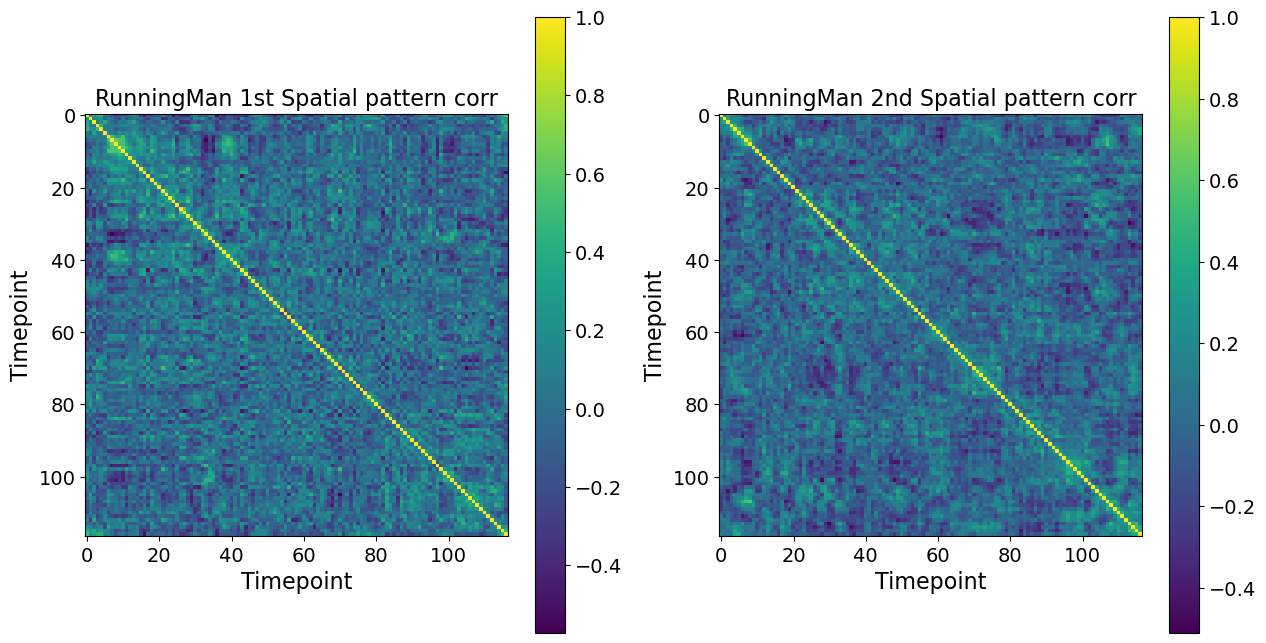

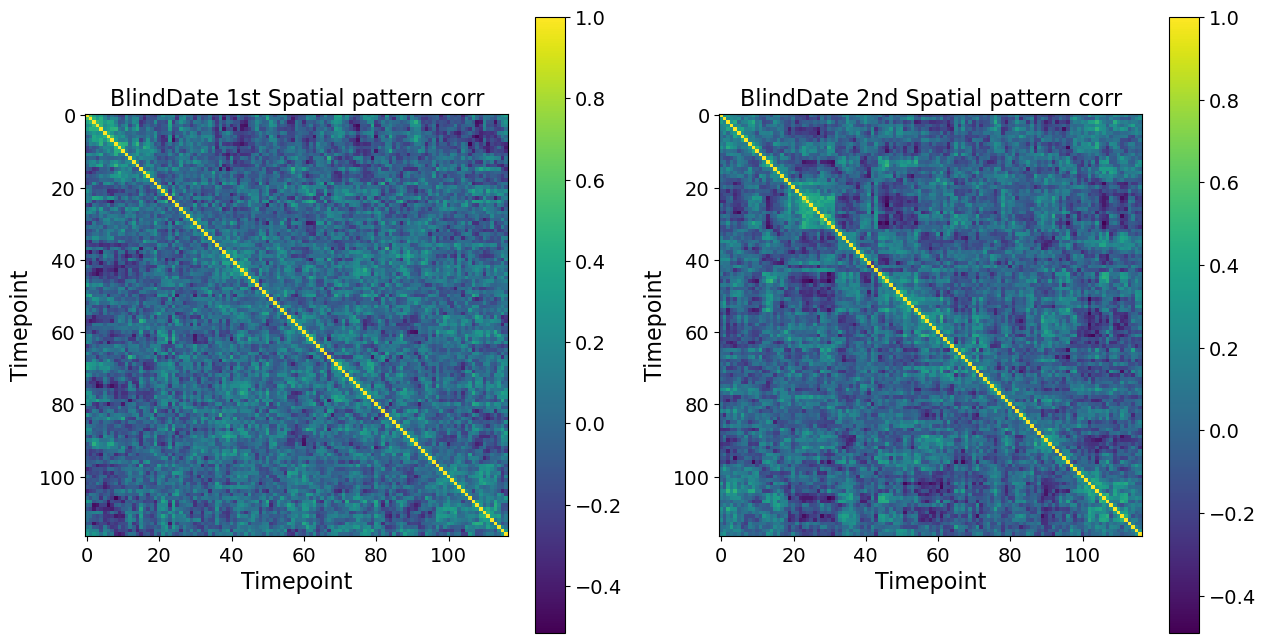

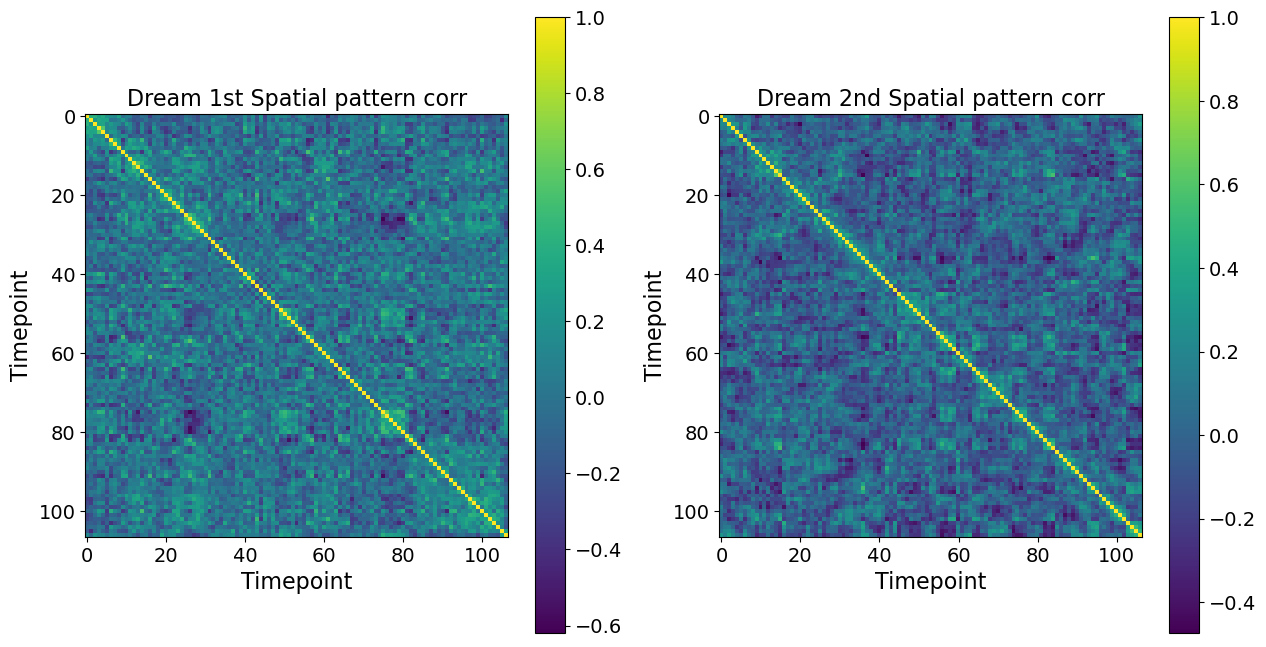

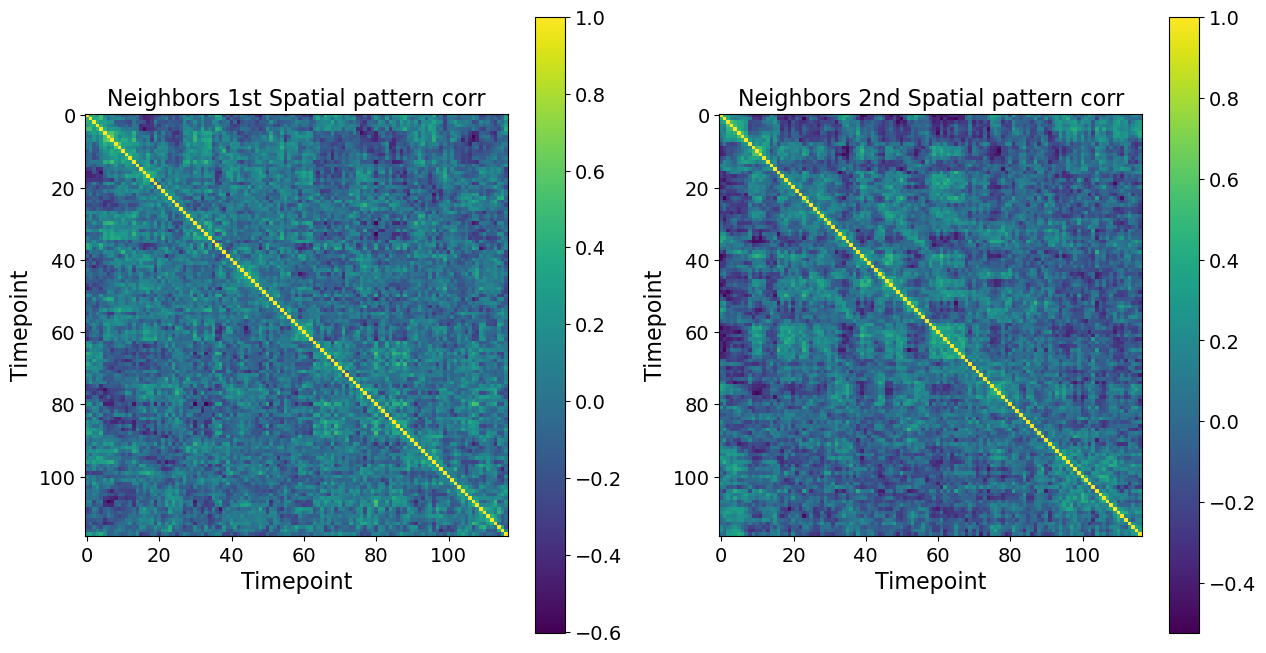

In [115]:
sequence = all_story['1']
# Event structure in activity patterns
for i in range(4):

    plt.figure(figsize=(15,8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.corrcoef( group_visual[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Spatial pattern corr');

    plt.subplot(1, 2, 2)
    plt.imshow(np.corrcoef( group_audio[i]))
    plt.xlabel('Timepoint')
    plt.ylabel('Timepoint')
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Spatial pattern corr');

<Figure size 1200x600 with 0 Axes>

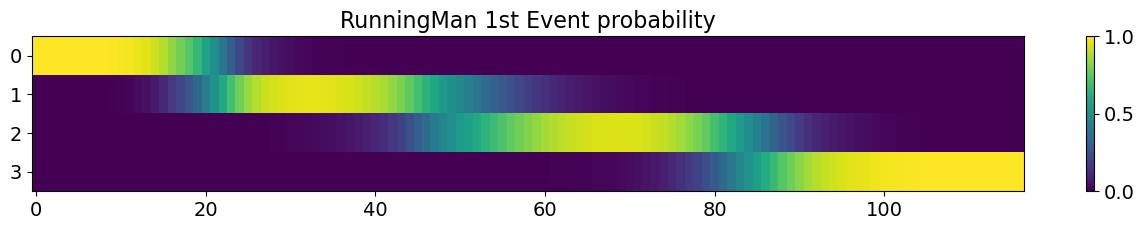

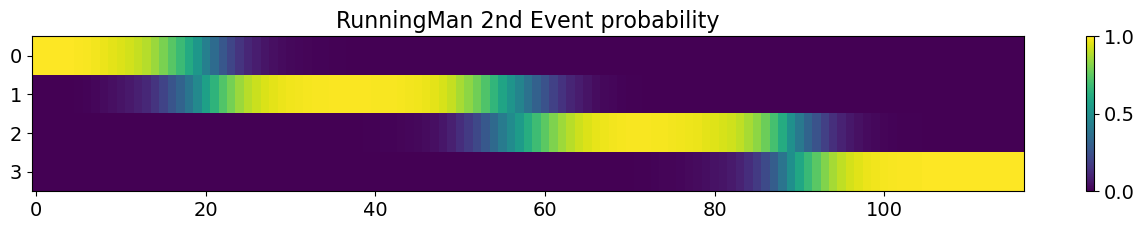

<Figure size 1200x600 with 0 Axes>

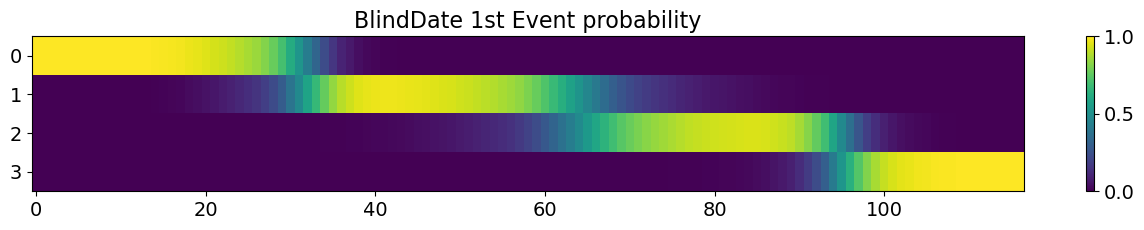

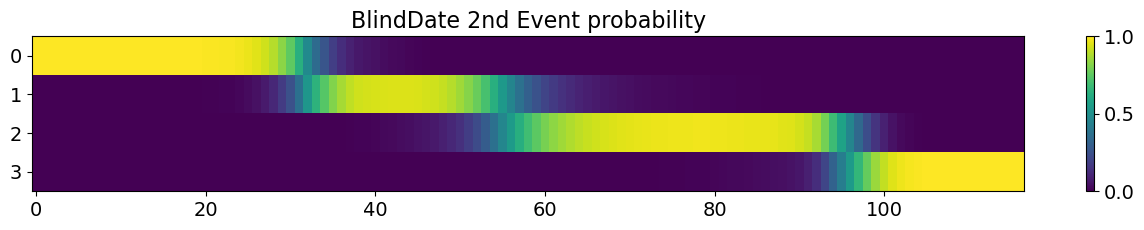

<Figure size 1200x600 with 0 Axes>

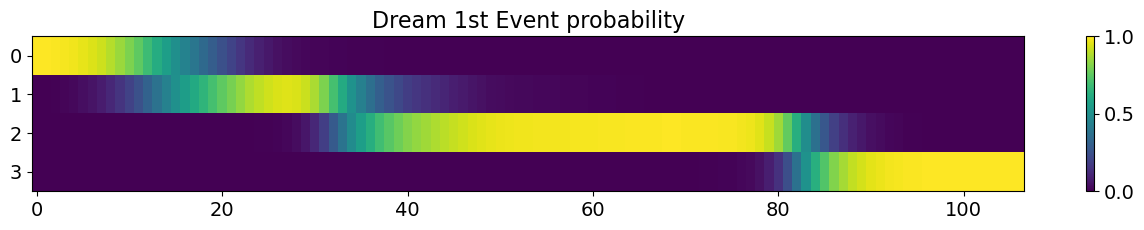

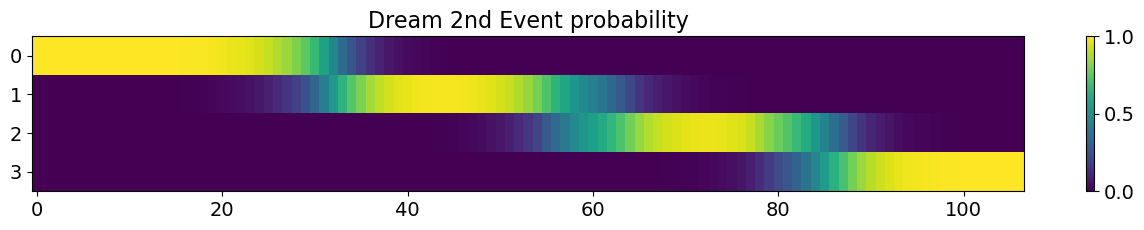

<Figure size 1200x600 with 0 Axes>

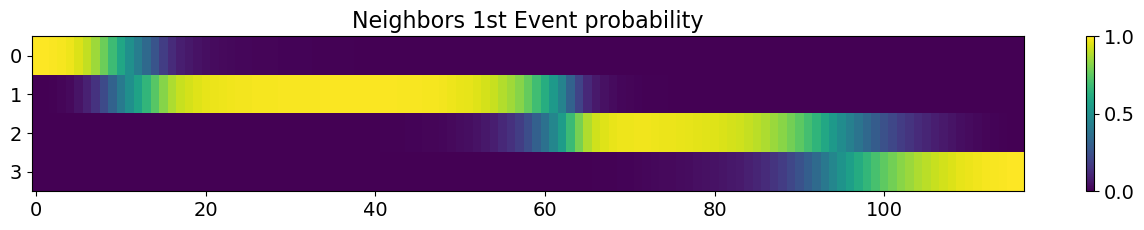

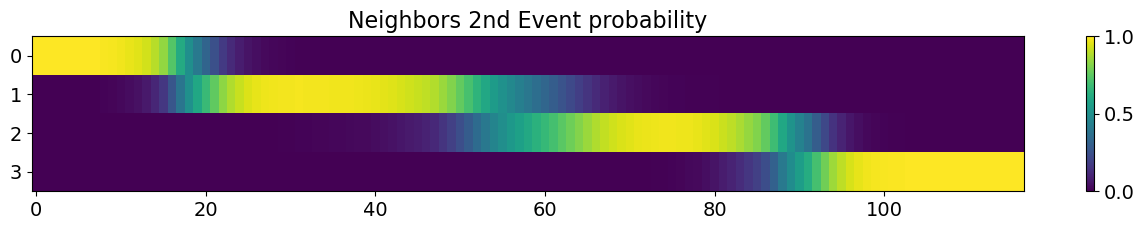

In [116]:
#Fitting the HMM
movie_HMM_v = {}
movie_HMM_a = {}
for i in range(4):
    movie_HMM_v[i] = EventSegment(n_events = 4)
    movie_HMM_v[i].fit(group_visual[i]);
    movie_HMM_a[i] = EventSegment(n_events = 4)
    movie_HMM_a[i].fit(group_audio[i]);
    
    plt.figure(figsize = (12, 6))
    
    plt.matshow(movie_HMM_v[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 1st Event probability')
    
    plt.matshow(movie_HMM_a[i].segments_[0].T, aspect='auto')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.title(f'{sequence[i]} 2nd Event probability')

# compare behav and fMRI

In [99]:
### Event boundary time-point(TRs)  at PCC

fRun_v=[11 , 59 , 91, 116] # 끝나는 지점
fRun_a=[21 , 50 , 92, 116]

fBlind_v=[7, 44, 87, 116]
fBlind_a=[17, 47,96, 116]

fDream_v=[9, 31, 81, 106]
fDream_a=[31, 57, 84, 106]

fNeigh_v=[10, 55, 97, 116]
fNeigh_a= [6, 30, 70, 116]


#Behavir EB

bRun_v= [14, 18, 33, 38, 88] # 시작하는 지점 
bRun_a= [15,38,47,88,107]

bBlind_v= [50, 58, 92]
bBlind_a= [24, 76, 94]  

bDream_v=[6, 18, 77] 
bDream_a= [7, 17, 78] 

bNeigh_v= [64, 84]
bNeigh_a= [11, 32, 44, 61, 84] 

In [100]:
predictor_all = np.zeros(117)
predictor_all2 = np.zeros(107)

predic_fv = {} 
predic_fa = {} 
predic_bv = {} 
predic_ba = {} 
for j in range(4):
    
    if j ==3:
        predictor_all2[fDream_v] = 1 
    else 
    predic_fv[j] = predictor_all[fRun_v] = 1  # 끝나는 지점
predic_fRun_a= predictor_all[fRun_a] = 1

# predic_fBlind_v= predictor_all[fBlind_v] = 1
# predic_fBlind_a= predictor_all[fBlind_a] = 1

# predic_fDream_v= predictor_all2[fDream_v]
# predic_fDream_a= predictor_all2[fDream_a] 

# predic_fNeigh_v= predictor_all[fNeigh_v] = 1
# predic_fNeigh_a= predictor_all[fNeigh_a] = 1


#Behavir EB

predic_bRun_v= predictor_all[bRun_v] = 1
predic_bRun_a=predictor_all[bRun_a] = 1

# predic_bBlind_v= predictor_all[bBlind_v] = 1
# predic_bBlind_a=predictor_all[bBlind_a] = 1

# predic_bDream_v= predictor_all2[bDream_v]
# predic_bDream_a= predictor_all2[bDream_a] 

# predic_bNeigh_v= predictor_all[bNeigh_v] = 1
# predic_bNeigh_a= predictor_all[bNeigh_a] = 1

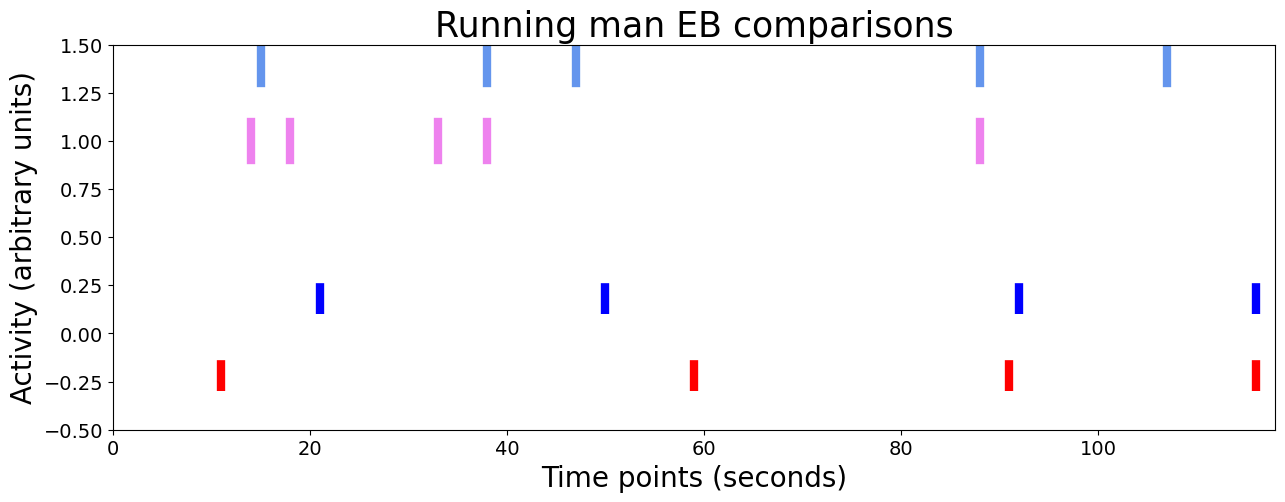

In [160]:
plt.figure(figsize=(15, 5))
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 118)
plt.ylim(-.5, 1.5)
plt.title('Running man EB comparisons', fontsize=25)
#plt.grid()

for k in fRun_v:
    plt.axvline(k,ymin=0.1, ymax=0.2, ls='--', c='r', linewidth=6)
for k in fRun_a:
    plt.axvline(k,ymin=0.3, ymax=0.4, ls='--', c='b', linewidth=6)     
for k in bRun_v:
    plt.axvline(k,ymin=0.7, ymax=0.8,  c='violet', linewidth=6)            
for k in bRun_a:
    plt.axvline(k,ymin=0.9, ymax=1,   c='cornflowerblue', linewidth=6)      
    
plt.show()

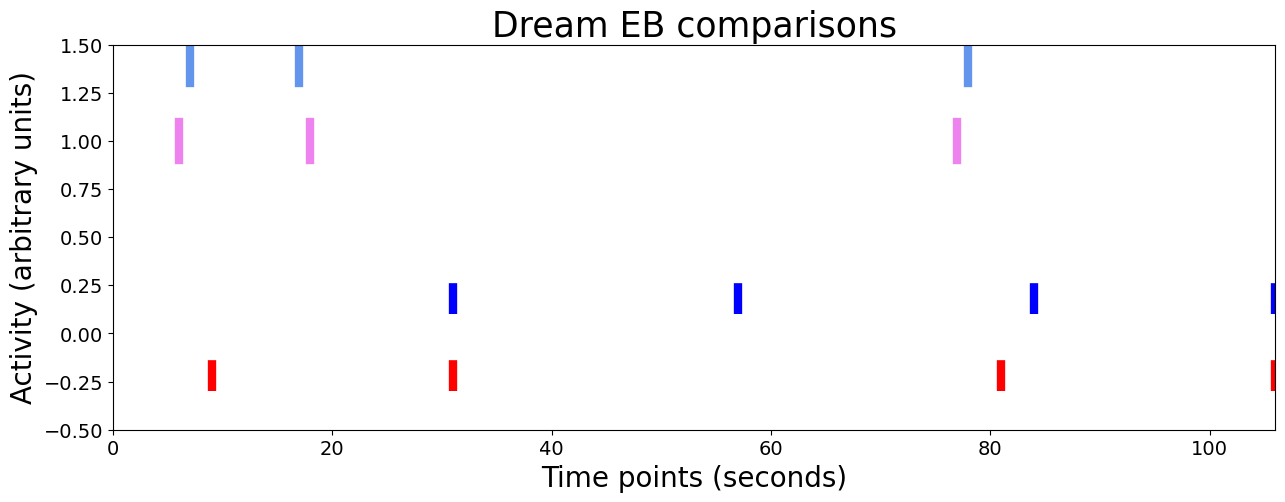

In [159]:
plt.figure(figsize=(15, 5))
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 106)
plt.ylim(-.5, 1.5)
plt.title('Dream EB comparisons', fontsize=25)
#plt.grid()

for k in fDream_v:
    plt.axvline(k,ymin=0.1, ymax=0.2, ls='--', c='r', linewidth=6)
for k in fDream_a:
    plt.axvline(k,ymin=0.3, ymax=0.4, ls='--', c='b', linewidth=6)     
for k in bDream_v:
    plt.axvline(k,ymin=0.7, ymax=0.8,  c='violet', linewidth=6)           
for k in bDream_a:
    plt.axvline(k,ymin=0.9, ymax=1,  c='cornflowerblue', linewidth=6)     
    
plt.show()

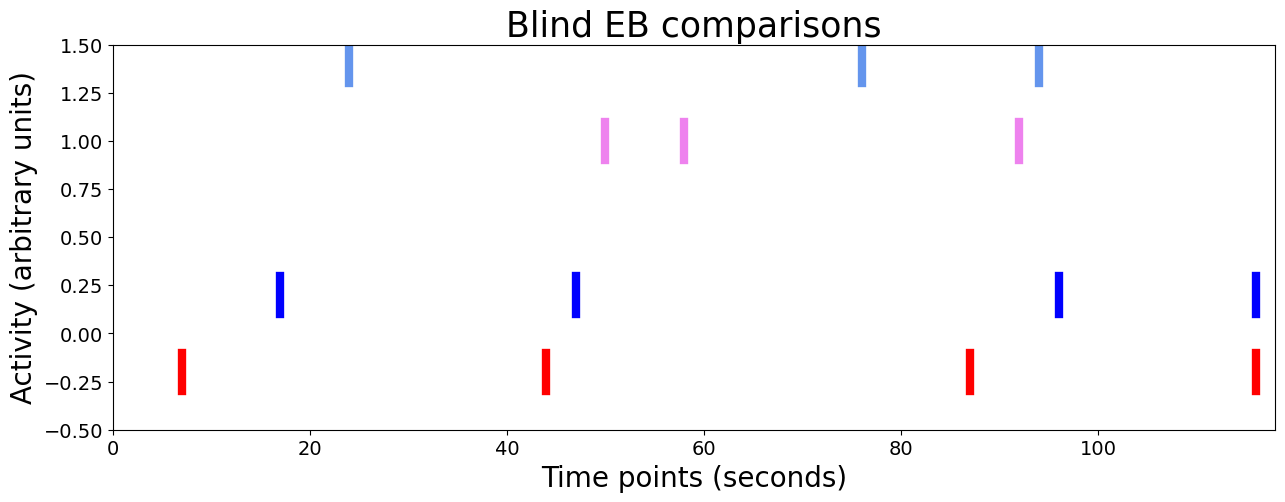

In [161]:
plt.figure(figsize=(15, 5))
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 118)
plt.ylim(-.5, 1.5)
plt.title('Blind EB comparisons', fontsize=25)
#plt.grid()

for k in fBlind_v:
    plt.axvline(k,ymin=0.1, ymax=0.2, c='r', linewidth=6)
for k in fBlind_a:
    plt.axvline(k,ymin=0.3, ymax=0.4,  c='b', linewidth=6)    
for k in bBlind_v:
    plt.axvline(k,ymin=0.7, ymax=0.8,  c='violet', linewidth=6)         
for k in bBlind_a:
    plt.axvline(k,ymin=0.9, ymax=1,  c='cornflowerblue', linewidth=6)  
    
plt.show()

In [2]:
plt.figure(figsize=(15, 5))
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 118)
plt.ylim(-.5, 1.5)
plt.title('Neigh EB comparisons', fontsize=25)
#plt.grid()

for k in fNeigh_v:
    plt.axvline(k,ymin=0.1, ymax=0.25, c='r', linewidth=6)
for k in fNeigh_a:
    plt.axvline(k,ymin=0.3, ymax=0.45, c='b', linewidth=6)       
for k in bNeigh_v:
    plt.axvline(k,ymin=0.7, ymax=0.8,  c='violet', linewidth=6)              
for k in bNeigh_a:
    plt.axvline(k,ymin=0.9, ymax=1,  c='cornflowerblue', linewidth=6)     
    
plt.show()

NameError: name 'plt' is not defined